In [1]:
import scipy.io as spio
from pypower.api import case118, ppoption, runpf
from pypower.runopf import runopf

In [2]:
import math
import numpy
import matplotlib.pyplot as plt
import time
import random
import logging
import pandas as pd

In [3]:
logger = logging.getLogger(__name__)
logger.addHandler(logging.StreamHandler())
logger.setLevel(logging.DEBUG)

In [4]:
hours = 24
total_inteval = int(60 * 60 * hours)
grantedtime = -1
pf_interval = 5 * 60  # in seconds (minimim_resolution)
acopf_interval = 15 * 60  # in seconds (minimim_resolution)
random.seed(0)

peak_demand = []
ppc = []
case_format = case118()
peak_demand = case_format["bus"][:, 2][:].copy()
ppc = case_format.copy()

In [5]:
case_format['bus'][117]

array([118.   ,   1.   ,  33.   ,  15.   ,   0.   ,   0.   ,   1.   ,
         0.949,  21.92 , 138.   ,   1.   ,   1.06 ,   0.94 ])

In [6]:
# load profiles (inputs)
profiles = spio.loadmat(
    "normalized_load_data_1min_ORIGINAL.mat", squeeze_me=True, struct_as_record=False
)
load_profiles_1min = profiles["my_data"]
resolution_load = numpy.floor(total_inteval / pf_interval)
points = numpy.floor(numpy.linspace(0, len(load_profiles_1min) - 1, resolution_load + 1))
time_pf = numpy.linspace(0, total_inteval, resolution_load + 1)
load_profiles = load_profiles_1min[points.astype(int), :]

In [7]:
load_profiles_1min[0:5]

array([[0.21781428, 0.29958296, 0.2417661 , 0.3212188 , 0.34557952,
        0.33071342, 0.37556301, 0.30134775, 0.33711165],
       [0.2167625 , 0.29818112, 0.2431469 , 0.3207291 , 0.34114479,
        0.33008039, 0.37559456, 0.30257265, 0.33574615],
       [0.21571072, 0.29677929, 0.24452769, 0.3202394 , 0.33671006,
        0.32944737, 0.3756261 , 0.30379754, 0.33438064],
       [0.21465894, 0.29537745, 0.24590849, 0.3197497 , 0.33227533,
        0.32881435, 0.37565764, 0.30502243, 0.33301514],
       [0.21360715, 0.29397562, 0.24728929, 0.31926   , 0.3278406 ,
        0.32818133, 0.37568919, 0.30624733, 0.33164963]])

In [8]:
resolution_load #how much loads data

288.0

In [9]:
points #each time stpes

array([   0.,    4.,    9.,   14.,   19.,   24.,   29.,   34.,   39.,
         44.,   49.,   54.,   59.,   64.,   69.,   74.,   79.,   84.,
         89.,   94.,   99.,  104.,  109.,  114.,  119.,  124.,  129.,
        134.,  139.,  144.,  149.,  154.,  159.,  164.,  169.,  174.,
        179.,  184.,  189.,  194.,  199.,  204.,  209.,  214.,  219.,
        224.,  229.,  234.,  239.,  244.,  249.,  254.,  259.,  264.,
        269.,  274.,  279.,  284.,  289.,  294.,  299.,  304.,  309.,
        314.,  319.,  324.,  329.,  334.,  339.,  344.,  349.,  354.,
        359.,  364.,  369.,  374.,  379.,  384.,  389.,  394.,  399.,
        404.,  409.,  414.,  419.,  424.,  429.,  434.,  439.,  444.,
        449.,  454.,  459.,  464.,  469.,  474.,  479.,  484.,  489.,
        494.,  499.,  504.,  509.,  514.,  519.,  524.,  529.,  534.,
        539.,  544.,  549.,  554.,  559.,  564.,  569.,  574.,  579.,
        584.,  589.,  594.,  599.,  604.,  609.,  614.,  619.,  624.,
        629.,  634.,

In [10]:
time_pf

array([    0.,   300.,   600.,   900.,  1200.,  1500.,  1800.,  2100.,
        2400.,  2700.,  3000.,  3300.,  3600.,  3900.,  4200.,  4500.,
        4800.,  5100.,  5400.,  5700.,  6000.,  6300.,  6600.,  6900.,
        7200.,  7500.,  7800.,  8100.,  8400.,  8700.,  9000.,  9300.,
        9600.,  9900., 10200., 10500., 10800., 11100., 11400., 11700.,
       12000., 12300., 12600., 12900., 13200., 13500., 13800., 14100.,
       14400., 14700., 15000., 15300., 15600., 15900., 16200., 16500.,
       16800., 17100., 17400., 17700., 18000., 18300., 18600., 18900.,
       19200., 19500., 19800., 20100., 20400., 20700., 21000., 21300.,
       21600., 21900., 22200., 22500., 22800., 23100., 23400., 23700.,
       24000., 24300., 24600., 24900., 25200., 25500., 25800., 26100.,
       26400., 26700., 27000., 27300., 27600., 27900., 28200., 28500.,
       28800., 29100., 29400., 29700., 30000., 30300., 30600., 30900.,
       31200., 31500., 31800., 32100., 32400., 32700., 33000., 33300.,
      

In [11]:
load_profiles[1]

array([0.21360715, 0.29397562, 0.24728929, 0.31926   , 0.3278406 ,
       0.32818133, 0.37568919, 0.30624733, 0.33164963])

In [12]:
bus_profiles_index = []
profile_number = 0
for i in range(len(ppc["bus"])):
    bus_profiles_index.append(profile_number)
    if profile_number == 8:
        profile_number = 0
    else:
        profile_number = profile_number + 1

In [13]:
###################   Asserting Profiles to buses    ############################

# bus_profiles_index = numpy.random.random_integers(0,load_profiles.shape[1]-1,len(ppc['bus']))
bus_profiles = load_profiles[:, bus_profiles_index]
time_opf = numpy.linspace(0, total_inteval, numpy.floor(total_inteval / acopf_interval) + 1)

In [14]:
len(bus_profiles_index)

118

In [15]:
len(time_pf)

289

In [16]:
peak_demand

array([ 51.,  20.,  39.,  39.,   0.,  52.,  19.,  28.,   0.,   0.,  70.,
        47.,  34.,  14.,  90.,  25.,  11.,  60.,  45.,  18.,  14.,  10.,
         7.,  13.,   0.,   0.,  71.,  17.,  24.,   0.,  43.,  59.,  23.,
        59.,  33.,  31.,   0.,   0.,  27.,  66.,  37.,  96.,  18.,  16.,
        53.,  28.,  34.,  20.,  87.,  17.,  17.,  18.,  23., 113.,  63.,
        84.,  12.,  12., 277.,  78.,   0.,  77.,   0.,   0.,   0.,  39.,
        28.,   0.,   0.,  66.,   0.,  12.,   6.,  68.,  47.,  68.,  61.,
        71.,  39., 130.,   0.,  54.,  20.,  11.,  24.,  21.,   0.,  48.,
         0., 163.,  10.,  65.,  12.,  30.,  42.,  38.,  15.,  34.,  42.,
        37.,  22.,   5.,  23.,  38.,  31.,  43.,  50.,   2.,   8.,  39.,
         0.,  68.,   6.,   8.,  22., 184.,  20.,  33.])

In [17]:
# Co-sim Bus  (inputs)
Cosim_bus_number = 118
cosim_bus = Cosim_bus_number - 1  ## Do not change this line
load_amplification_factor = 15

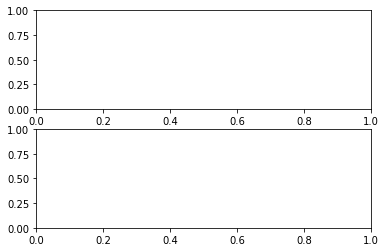

In [18]:
# power_flow
fig = plt.figure()
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
voltage_plot = []
x = 0
k = 0
voltage_cosim_bus = (ppc["bus"][cosim_bus, 7] * ppc["bus"][cosim_bus, 9]) * 1.043

In [19]:
ppc["bus"][:, 3]

array([ 27.,   9.,  10.,  12.,   0.,  22.,   2.,   0.,   0.,   0.,  23.,
        10.,  16.,   1.,  30.,  10.,   3.,  34.,  25.,   3.,   8.,   5.,
         3.,   0.,   0.,   0.,  13.,   7.,   4.,   0.,  27.,  23.,   9.,
        26.,   9.,  17.,   0.,   0.,  11.,  23.,  10.,  23.,   7.,   8.,
        22.,  10.,   0.,  11.,  30.,   4.,   8.,   5.,  11.,  32.,  22.,
        18.,   3.,   3., 113.,   3.,   0.,  14.,   0.,   0.,   0.,  18.,
         7.,   0.,   0.,  20.,   0.,   0.,   0.,  27.,  11.,  36.,  28.,
        26.,  32.,  26.,   0.,  27.,  10.,   7.,  15.,  10.,   0.,  10.,
         0.,  42.,   0.,  10.,   7.,  16.,  31.,  15.,   9.,   8.,   0.,
        18.,  15.,   3.,  16.,  25.,  26.,  16.,  12.,   1.,   3.,  30.,
         0.,  13.,   0.,   3.,   7.,   0.,   8.,  15.])

In [20]:
power_load = []

In [21]:
voltage_cosim_v = []

In [22]:
for t in range(0, total_inteval, pf_interval):
    voltage_gld = complex(voltage_cosim_bus * 1000)
    if t == 0:
        voltage_cosim_v.append(voltage_gld)
    else:
        for i in range(0, 5):
            voltage_cosim_v.append(voltage_gld)
    time.sleep(0.1)
    actual_demand = peak_demand * bus_profiles[x, :]
    ppc["bus"][:, 2] = actual_demand
    ppc["bus"][:, 3] = actual_demand * math.tan(math.acos(0.85))
    
    print("++++ ppc['bus'][cosim_bus, 2]", ppc["bus"][cosim_bus, 2], "+++++ppc['bus'][cosim_bus, 2]", ppc["bus"][cosim_bus, 3])
    ppopt = ppoption(PF_ALG=1)
    print("PF TIme is {} and ACOPF time is {}".format(time_pf[x], time_opf[k]))
    ############################  Running OPF For optimal power flow intervals   ##############################

#     if time_pf[x] == time_opf[k]:
#         results_opf = runopf(ppc, ppopt)
#         if results_opf["success"]:
#             ppc["bus"] = results_opf["bus"]
#             ppc["gen"] = results_opf["gen"]
#             if k == 0:
#                 LMP_solved = results_opf["bus"][:, 13]
#             else:
#                 LMP_solved = numpy.vstack((LMP_solved, results_opf["bus"][:, 13]))
#                 opf_time = time_opf[0 : k + 1] / 3600
#         k = k + 1
    power_load.append(ppc["bus"][:, 2])
    ################################  Running PF For optimal power flow intervals   ##############################
#     print("ppc", ppc)
    solved_pf = runpf(ppc, ppopt)
    results_pf = solved_pf[0]
    ppc["bus"] = results_pf["bus"]
    ppc["gen"] = results_pf["gen"]

    if x == 1 :
        print("results_pf", results_pf)

    if results_pf["success"] == 1:
        if x == 0:
            voltages = results_pf["bus"][:, 7]
            real_demand = results_pf["bus"][:, 2]
#             distribution_load = [rload / 1000000]
        else:
            voltages = numpy.vstack((voltages, results_pf["bus"][:, 7]))
            real_demand = numpy.vstack((real_demand, results_pf["bus"][:, 2]))
#             distribution_load.append(rload / 1000000)
            pf_time = time_pf[0 : x + 1] / 3600

        voltage_cosim_bus = results_pf["bus"][cosim_bus, 7] * results_pf["bus"][cosim_bus, 9]
        print("&&&&&& results_pf['bus'][cosim_bus, 7] = ", results_pf["bus"][cosim_bus, 7], "   &&&&&&&&results_pf['bus'][cosim_bus, 9] = ", results_pf["bus"][cosim_bus, 9])
        voltage_plot.append(voltage_cosim_bus)
    x = x + 1
for i in range(0, 4):
    voltage_cosim_v.append(voltage_gld)

++++ ppc['bus'][cosim_bus, 2] 7.187871373546629 +++++ppc['bus'][cosim_bus, 2] 4.454642588925253
PF TIme is 0.0 and ACOPF time is 0.0
PYPOWER Version 5.1.4, 27-June-2018 -- AC Power Flow (Newton)


Newton's method power flow converged in 4 iterations.

Converged in 0.04 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   1706.4            1741.4
Loads             99     Load                  1331.1             824.9
  Fixed           99       Fixed               1331.1             824.9
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (inj)    

PYPOWER Version 5.1.4, 27-June-2018 -- AC Power Flow (Newton)


Newton's method power flow converged in 2 iterations.

Converged in 0.11 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   1683.2            1763.2
Loads             99     Load                  1301.7             806.7
  Fixed           99       Fixed               1301.7             806.7
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (inj)             -0.0              85.9
Branches         186     Losses (I^2 * Z)       381.50           2380.53
Transformers       9     Bra

++++ ppc['bus'][cosim_bus, 2] 7.099913521314006 +++++ppc['bus'][cosim_bus, 2] 4.400131207985989
PF TIme is 900.0 and ACOPF time is 0.0
PYPOWER Version 5.1.4, 27-June-2018 -- AC Power Flow (Newton)


Newton's method power flow converged in 2 iterations.

Converged in 0.03 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   1670.0            1777.6
Loads             99     Load                  1284.3             796.0
  Fixed           99       Fixed               1284.3             796.0
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (inj)  


Newton's method power flow converged in 2 iterations.

Converged in 0.11 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   1634.4            1812.2
Loads             99     Load                  1238.7             767.7
  Fixed           99       Fixed               1238.7             767.7
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (inj)             -0.0              85.8
Branches         186     Losses (I^2 * Z)       395.67           2468.28
Transformers       9     Branch Charging (inj)     -             1337.9
Inter-ties         


Newton's method power flow converged in 2 iterations.

Converged in 0.17 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   1633.7            1814.6
Loads             99     Load                  1237.3             766.8
  Fixed           99       Fixed               1237.3             766.8
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (inj)             -0.0              85.9
Branches         186     Losses (I^2 * Z)       396.37           2471.46
Transformers       9     Branch Charging (inj)     -             1337.9
Inter-ties         

  83     54     59    -12.16    -12.43     12.30      7.41     0.134      0.61
  84     56     59    -11.96    -10.32     12.14      5.53     0.184      0.56
  85     56     59    -12.59    -10.46     12.78      6.01     0.197      0.58
  86     55     59    -13.12    -14.11     13.28      9.54     0.160      0.73
  87     59     60     -4.56     -6.38      4.57      2.76     0.014      0.06
  88     59     61     -7.07     -6.88      7.09      3.19     0.025      0.12
  89     60     61    -29.71     -8.21     29.74      6.90     0.025      0.13
  90     60     62      1.05     -9.48     -1.04      8.07     0.010      0.04
  91     61     62     12.31    -11.08    -12.29     10.21     0.022      0.10
  92     63     59    -32.73     77.53     32.73    -74.87    -0.000      2.66
  93     63     64     32.73    -77.53    -32.63     57.95     0.102      1.18
  94     64     61   -110.86     28.39    110.86    -24.90    -0.000      3.49
  95     38     65    266.21    -85.06   -259.01    

++++ ppc['bus'][cosim_bus, 2] 6.731210447009502 +++++ppc['bus'][cosim_bus, 2] 4.171629565133954
PF TIme is 3000.0 and ACOPF time is 0.0
PYPOWER Version 5.1.4, 27-June-2018 -- AC Power Flow (Newton)


Newton's method power flow converged in 2 iterations.

Converged in 0.02 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   1601.5            1848.0
Loads             99     Load                  1195.7             741.0
  Fixed           99       Fixed               1195.7             741.0
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (inj) 

++++ ppc['bus'][cosim_bus, 2] 6.669365295198866 +++++ppc['bus'][cosim_bus, 2] 4.1333013824416325
PF TIme is 3300.0 and ACOPF time is 0.0
PYPOWER Version 5.1.4, 27-June-2018 -- AC Power Flow (Newton)


Newton's method power flow converged in 2 iterations.

Converged in 0.02 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   1594.5            1854.7
Loads             99     Load                  1186.6             735.4
  Fixed           99       Fixed               1186.6             735.4
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (inj)


Newton's method power flow converged in 2 iterations.

Converged in 0.02 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   1590.5            1860.3
Loads             99     Load                  1181.1             732.0
  Fixed           99       Fixed               1181.1             732.0
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (inj)             -0.0              85.9
Branches         186     Losses (I^2 * Z)       409.34           2551.74
Transformers       9     Branch Charging (inj)     -             1337.6
Inter-ties         

   35  0.981   79.105       -         -        9.04      5.60 
   36  0.980   79.113      0.00    -12.10      9.38      5.82 
   37  0.987   79.302       -         -         -         -   
   38  0.951   81.106       -         -         -         -   
   39  0.974   75.851       -         -        6.00      3.72 
   40  0.970   74.049      0.00     -8.14     16.08      9.96 
   41  0.971   72.645       -         -       10.34      6.41 
   42  0.985   69.535      0.00     15.92     28.96     17.95 
   43  0.990   73.959       -         -        6.43      3.98 
   44  1.012   67.445       -         -        4.38      2.72 
   45  1.013   65.481       -         -       16.04      9.94 
   46  1.005   63.826     19.00    -26.04      5.79      3.59 
   47  0.998   60.259       -         -        8.91      5.52 
   48  1.026   64.872       -         -        4.45      2.76 
   49  1.025   65.419    204.00    101.43     21.19     13.13 
   50  1.006   65.624       -         -        4.75    

   94  0.989   79.641       -         -        7.30      4.52 
   95  0.984   76.238       -         -       12.01      7.44 
   96  0.987   72.255       -         -       11.47      7.11 
   97  1.009   67.828       -         -        5.36      3.32 
   98  1.016   70.084       -         -        9.39      5.82 
   99  1.010   76.292      0.00      2.18     12.97      8.04 
  100  1.017   81.928    252.00     85.68      7.53      4.67 
  101  1.002   84.980       -         -        5.91      3.66 
  102  0.994   88.126       -         -        1.12      0.69 
  103  1.010   82.260     40.00     43.75      5.60      3.47 
  104  0.971   81.728      0.00    -25.59     10.87      6.73 
  105  0.965   81.647      0.00    -59.34      9.36      5.80 
  106  0.968   81.222       -         -       15.35      9.52 
  107  0.952   80.827      0.00    -12.04     13.81      8.56 
  108  0.968   81.954       -         -        0.62      0.38 
  109  0.970   82.095       -         -        1.63    

&&&&&& results_pf['bus'][cosim_bus, 7] =  0.9538352202686693    &&&&&&&&results_pf['bus'][cosim_bus, 9] =  138.0
++++ ppc['bus'][cosim_bus, 2] 6.433351235403754 +++++ppc['bus'][cosim_bus, 2] 3.9870330051000806
PF TIme is 4800.0 and ACOPF time is 0.0
PYPOWER Version 5.1.4, 27-June-2018 -- AC Power Flow (Newton)


Newton's method power flow converged in 2 iterations.

Converged in 0.02 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   1577.1            1875.0
Loads             99     Load                  1163.7             721.2
  Fixed           99       Fixed               1163.7             7

++++ ppc['bus'][cosim_bus, 2] 6.4793587979420195 +++++ppc['bus'][cosim_bus, 2] 4.015545931506897
PF TIme is 5100.0 and ACOPF time is 0.0
PYPOWER Version 5.1.4, 27-June-2018 -- AC Power Flow (Newton)


Newton's method power flow converged in 2 iterations.

Converged in 0.03 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   1572.3            1880.6
Loads             99     Load                  1157.3             717.3
  Fixed           99       Fixed               1157.3             717.3
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (inj)


Newton's method power flow converged in 2 iterations.

Converged in 0.02 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   1559.4            1894.5
Loads             99     Load                  1140.4             706.8
  Fixed           99       Fixed               1140.4             706.8
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (inj)             -0.0              85.9
Branches         186     Losses (I^2 * Z)       419.02           2610.94
Transformers       9     Branch Charging (inj)     -             1337.4
Inter-ties         

    4  0.998   99.825      0.00    -23.87      9.07      5.62 
    5  1.001   99.997       -         -         -         -   
    6  0.990   98.912      0.00     -5.54     15.22      9.43 
    7  0.989   98.637       -         -        6.51      4.03 
    8  1.015  102.151      0.00     75.40      7.73      4.79 
    9  1.043  109.405       -         -         -         -   
   10  1.050  116.986    450.00    -51.04       -         -   
   11  0.990   98.439       -         -       17.94     11.12 
   12  0.990   98.298     85.00     33.14      9.89      6.13 
   13  0.982   96.436       -         -        7.90      4.90 
   14  0.983   96.185       -         -        3.81      2.36 
   15  0.970   90.711      0.00    -16.33     26.35     16.33 
   16  0.987   96.012       -         -        8.56      5.31 
   17  0.991   91.933       -         -        3.04      1.88 
   18  0.973   90.569      0.00      2.27     17.97     11.13 
   19  0.962   89.676      0.00    -48.45      9.05    

   39  0.974   76.746       -         -        5.79      3.59 
   40  0.970   74.939      0.00     -8.99     15.31      9.49 
   41  0.971   73.523       -         -        9.93      6.16 
   42  0.985   70.355      0.00     15.08     27.60     17.10 
   43  0.990   74.780       -         -        6.16      3.82 
   44  1.012   68.127       -         -        4.34      2.69 
   45  1.013   66.112       -         -       15.76      9.77 
   46  1.005   64.403     19.00    -25.89      5.53      3.42 
   47  0.998   60.770       -         -        8.58      5.32 
   48  1.026   65.448       -         -        4.29      2.66 
   49  1.025   65.991    204.00    103.09     20.18     12.51 
   50  1.006   66.221       -         -        4.56      2.83 
   51  0.983   66.476       -         -        4.89      3.03 
   52  0.976   66.481       -         -        6.16      3.82 
   53  0.963   66.983       -         -        6.24      3.87 
   54  0.955   67.810     48.00    -45.41     33.60    

   37  0.987   80.195       -         -         -         -   
   38  0.950   81.948       -         -         -         -   
   39  0.974   76.745       -         -        5.77      3.58 
   40  0.970   74.937      0.00     -8.90     15.21      9.43 
   41  0.971   73.516       -         -       10.21      6.33 
   42  0.985   70.356      0.00     14.86     27.25     16.89 
   43  0.990   74.778       -         -        6.15      3.81 
   44  1.012   68.119       -         -        4.27      2.64 
   45  1.013   66.099       -         -       15.84      9.82 
   46  1.005   64.392     19.00    -26.00      5.32      3.30 
   47  0.998   60.751       -         -        8.87      5.50 
   48  1.026   65.430       -         -        4.28      2.65 
   49  1.025   65.971    204.00    103.03     20.05     12.42 
   50  1.006   66.191       -         -        4.69      2.91 
   51  0.983   66.444       -         -        4.83      2.99 
   52  0.976   66.448       -         -        6.15    

   62  0.998   69.051      0.00    -18.19     21.06     13.05 
   63  0.974   68.096       -         -         -         -   
   64  0.987   67.579       -         -         -         -   
   65  1.005   64.809    391.00    271.93       -         -   
   66  1.050   69.116    392.00     17.26      8.17      5.06 
   67  1.025   68.904       -         -        6.37      3.95 
   68  0.989   55.214       -         -         -         -   
   69  1.035   30.000* -2304.40    926.75       -         -   
   70  0.984   45.270      0.00     37.49     22.84     14.15 
   71  0.983   47.962       -         -         -         -   
   72  0.980   62.476      0.00     30.01      3.59      2.23 
   73  0.991   47.845      0.00     17.22      1.15      0.71 
   74  0.958   44.262      0.00    -38.20     17.79     11.02 
   75  0.968   44.119       -         -        9.84      6.10 
   76  0.943   49.439      0.00    -38.97     15.47      9.59 
   77  1.006   57.195      0.00    134.29     17.36    

++++ ppc['bus'][cosim_bus, 2] 6.3780102325784185 +++++ppc['bus'][cosim_bus, 2] 3.9527357319175285
PF TIme is 7500.0 and ACOPF time is 0.0
PYPOWER Version 5.1.4, 27-June-2018 -- AC Power Flow (Newton)


Newton's method power flow converged in 2 iterations.

Converged in 0.02 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   1542.6            1913.3
Loads             99     Load                  1118.4             693.1
  Fixed           99       Fixed               1118.4             693.1
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (inj


Newton's method power flow converged in 2 iterations.

Converged in 0.30 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   1531.2            1927.5
Loads             99     Load                  1103.1             683.6
  Fixed           99       Fixed               1103.1             683.6
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (inj)             -0.0              85.9
Branches         186     Losses (I^2 * Z)       428.10           2666.86
Transformers       9     Branch Charging (inj)     -             1337.2
Inter-ties         

   92  0.990   91.157      0.00    -20.77     16.70     10.35 
   93  0.985   85.590       -         -        2.50      1.55 
   94  0.989   80.894       -         -        6.57      4.07 
   95  0.984   77.427       -         -       11.26      6.98 
   96  0.986   73.343       -         -       10.71      6.64 
   97  1.009   68.789       -         -        5.09      3.16 
   98  1.016   71.099       -         -        9.05      5.61 
   99  1.010   77.502      0.00      2.15     11.76      7.29 
  100  1.017   83.242    252.00     86.98      6.99      4.33 
  101  1.002   86.338       -         -        5.65      3.50 
  102  0.994   89.510       -         -        1.04      0.65 
  103  1.010   83.673     40.00     43.14      5.04      3.12 
  104  0.971   83.187      0.00    -26.17     10.18      6.31 
  105  0.965   83.128      0.00    -60.36      8.74      5.42 
  106  0.968   82.695       -         -       14.60      9.05 
  107  0.952   82.337      0.00    -12.63     13.31    

   94  0.989   80.683       -         -        6.66      4.13 
   95  0.984   77.227       -         -       11.36      7.04 
   96  0.986   73.158       -         -       10.75      6.66 
   97  1.009   68.622       -         -        5.17      3.20 
   98  1.016   70.919       -         -        9.23      5.72 
   99  1.010   77.292      0.00      2.26     12.08      7.48 
  100  1.017   83.020    252.00     86.92      7.25      4.49 
  101  1.002   86.117       -         -        5.52      3.42 
  102  0.994   89.282       -         -        1.05      0.65 
  103  1.010   83.440     40.00     43.20      5.10      3.16 
  104  0.971   82.945      0.00    -26.09     10.28      6.37 
  105  0.965   82.882      0.00    -60.16      8.77      5.44 
  106  0.968   82.446       -         -       14.81      9.18 
  107  0.952   82.073      0.00    -12.36     13.57      8.41 
  108  0.968   83.230       -         -        0.58      0.36 
  109  0.970   83.388       -         -        1.57    

   91  0.980   93.269      0.00    -13.36      1.94      1.20 
   92  0.990   90.917      0.00    -21.12     16.45     10.19 
   93  0.985   85.357       -         -        2.47      1.53 
   94  0.989   80.666       -         -        6.80      4.22 
   95  0.984   77.208       -         -       11.63      7.21 
   96  0.986   73.143       -         -       10.70      6.63 
   97  1.009   68.612       -         -        5.03      3.12 
   98  1.016   70.903       -         -        9.26      5.74 
   99  1.010   77.276      0.00      2.19     12.01      7.44 
  100  1.017   83.000    252.00     86.91      7.19      4.46 
  101  1.002   86.100       -         -        5.57      3.45 
  102  0.994   89.271       -         -        1.03      0.64 
  103  1.010   83.411     40.00     43.32      5.22      3.23 
  104  0.971   82.914      0.00    -25.88     10.52      6.52 
  105  0.965   82.855      0.00    -60.46      8.73      5.41 
  106  0.968   82.428       -         -       14.42    

   94  0.989   80.582       -         -        6.84      4.24 
   95  0.984   77.128       -         -       11.71      7.26 
   96  0.986   73.071       -         -       10.66      6.60 
   97  1.009   68.547       -         -        5.11      3.17 
   98  1.016   70.839       -         -        9.23      5.72 
   99  1.010   77.194      0.00      2.25     12.17      7.54 
  100  1.017   82.913    252.00     86.83      7.29      4.52 
  101  1.002   86.012       -         -        5.48      3.40 
  102  0.994   89.177       -         -        1.05      0.65 
  103  1.010   83.321     40.00     43.34      5.24      3.25 
  104  0.971   82.821      0.00    -25.81     10.60      6.57 
  105  0.965   82.762      0.00    -60.33      8.69      5.39 
  106  0.968   82.331       -         -       14.66      9.09 
  107  0.952   81.956      0.00    -12.39     13.57      8.41 
  108  0.968   83.102       -         -        0.58      0.36 
  109  0.970   83.257       -         -        1.58    

  102  0.994   89.431       -         -        1.04      0.65 
  103  1.010   83.594     40.00     43.18      5.08      3.15 
  104  0.971   83.106      0.00    -26.00     10.38      6.43 
  105  0.965   83.051      0.00    -60.49      8.69      5.39 
  106  0.968   82.623       -         -       14.41      8.93 
  107  0.952   82.265      0.00    -12.70     13.28      8.23 
  108  0.968   83.395       -         -        0.57      0.35 
  109  0.970   83.551       -         -        1.57      0.98 
  110  0.973   84.041      0.00    -32.79      9.90      6.13 
  111  0.980   85.686     36.00     -1.84       -         -   
  112  0.975   83.326      0.00     15.33     15.03      9.31 
  113  0.993   92.572      0.00     19.40      1.64      1.02 
  114  0.963   92.628       -         -        2.24      1.39 
  115  0.963   92.714       -         -        7.37      4.57 
  116  1.005   55.300      0.00    421.57     48.86     30.28 
  117  0.986   98.762       -         -        5.67    

  114  0.963   92.613       -         -        2.26      1.40 
  115  0.963   92.699       -         -        7.34      4.55 
  116  1.005   55.275      0.00    421.50     49.47     30.66 
  117  0.986   98.738       -         -        5.56      3.45 
  118  0.954   46.681       -         -        6.50      4.03 
                        --------  --------  --------  --------
               Total:   1534.67   1923.69   1107.62    686.44

|     Branch Data                                                              |
Brnch   From   To    From Bus Injection   To Bus Injection     Loss (I^2 * Z)  
  #     Bus    Bus    P (MW)   Q (MVAr)   P (MW)   Q (MVAr)   P (MW)   Q (MVAr)
-----  -----  -----  --------  --------  --------  --------  --------  --------
   0      1      2      1.31    -21.19     -1.18     19.26     0.134      0.44
   1      1      3    -11.37    -33.00     11.53     32.55     0.168      0.55
   2      4      5    -43.63    -29.70     43.68     29.72     0.049      0.22
 

&&&&&& results_pf['bus'][cosim_bus, 7] =  0.9536748088545682    &&&&&&&&results_pf['bus'][cosim_bus, 9] =  138.0
++++ ppc['bus'][cosim_bus, 2] 6.402125168963265 +++++ppc['bus'][cosim_bus, 2] 3.967680827212988
PF TIme is 10500.0 and ACOPF time is 0.0
PYPOWER Version 5.1.4, 27-June-2018 -- AC Power Flow (Newton)


Newton's method power flow converged in 2 iterations.

Converged in 0.02 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   1535.4            1921.6
Loads             99     Load                  1108.9             687.2
  Fixed           99       Fixed               1108.9             6

 182     68    116     49.16   -400.38    -48.62    390.55     0.543      6.47
 183     12    117      5.68      0.07     -5.67     -3.51     0.012      0.05
 184     75    118    -65.15     48.63     66.18    -46.31     1.032      3.42
 185     76    118     73.86    -39.31    -72.58     42.34     1.282      4.25
                                                             --------  --------
                                                    Total:   426.504   2657.45
&&&&&& results_pf['bus'][cosim_bus, 7] =  0.953758242982636    &&&&&&&&results_pf['bus'][cosim_bus, 9] =  138.0
++++ ppc['bus'][cosim_bus, 2] 6.482916819907741 +++++ppc['bus'][cosim_bus, 2] 4.017750995476066
PF TIme is 10800.0 and ACOPF time is 0.0
PYPOWER Version 5.1.4, 27-June-2018 -- AC Power Flow (Newton)


Newton's method power flow converged in 2 iterations.

Converged in 0.03 seconds
|     System Summary                                                           |

How many?                How much?              P

++++ ppc['bus'][cosim_bus, 2] 6.504512362890423 +++++ppc['bus'][cosim_bus, 2] 4.0311347109743245
PF TIme is 11100.0 and ACOPF time is 0.0
PYPOWER Version 5.1.4, 27-June-2018 -- AC Power Flow (Newton)


Newton's method power flow converged in 2 iterations.

Converged in 0.03 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   1539.1            1916.3
Loads             99     Load                  1114.0             690.4
  Fixed           99       Fixed               1114.0             690.4
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (inj

++++ ppc['bus'][cosim_bus, 2] 6.395017667378745 +++++ppc['bus'][cosim_bus, 2] 3.963275993345791
PF TIme is 11400.0 and ACOPF time is 0.0
PYPOWER Version 5.1.4, 27-June-2018 -- AC Power Flow (Newton)


Newton's method power flow converged in 2 iterations.

Converged in 0.03 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   1534.4            1921.4
Loads             99     Load                  1108.0             686.7
  Fixed           99       Fixed               1108.0             686.7
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (inj)


Newton's method power flow converged in 2 iterations.

Converged in 0.02 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   1543.5            1912.3
Loads             99     Load                  1119.5             693.8
  Fixed           99       Fixed               1119.5             693.8
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (inj)             -0.0              85.9
Branches         186     Losses (I^2 * Z)       423.95           2641.57
Transformers       9     Branch Charging (inj)     -             1337.3
Inter-ties         


Newton's method power flow converged in 2 iterations.

Converged in 0.03 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   1540.0            1916.1
Loads             99     Load                  1114.8             690.9
  Fixed           99       Fixed               1114.8             690.9
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (inj)             -0.0              85.9
Branches         186     Losses (I^2 * Z)       425.16           2648.28
Transformers       9     Branch Charging (inj)     -             1337.2
Inter-ties         


Newton's method power flow converged in 2 iterations.

Converged in 0.02 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   1539.2            1916.3
Loads             99     Load                  1114.1             690.4
  Fixed           99       Fixed               1114.1             690.4
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (inj)             -0.0              85.9
Branches         186     Losses (I^2 * Z)       425.14           2648.96
Transformers       9     Branch Charging (inj)     -             1337.2
Inter-ties         

   31  0.967   92.385      7.00     -4.82      9.56      5.93 
   32  0.963   92.075      0.00    -46.64     16.23     10.06 
   33  0.971   86.042       -         -        6.61      4.10 
   34  0.984   80.478      0.00     -0.61     20.52     12.72 
   35  0.981   80.390       -         -        8.70      5.39 
   36  0.980   80.399      0.00    -12.67      8.68      5.38 
   37  0.987   80.574       -         -         -         -   
   38  0.950   82.314       -         -         -         -   
   39  0.974   77.122       -         -        5.54      3.43 
   40  0.970   75.305      0.00     -9.38     14.68      9.10 
   41  0.971   73.872       -         -       10.18      6.31 
   42  0.985   70.674      0.00     15.32     27.59     17.10 
   43  0.990   75.130       -         -        6.26      3.88 
   44  1.012   68.450       -         -        4.22      2.61 
   45  1.014   66.420       -         -       14.84      9.20 
   46  1.005   64.672     19.00    -26.16      5.46    

   36  0.980   80.619      0.00    -12.71      8.60      5.33 
   37  0.987   80.791       -         -         -         -   
   38  0.950   82.518       -         -         -         -   
   39  0.974   77.330       -         -        5.55      3.44 
   40  0.970   75.509      0.00     -9.23     14.87      9.21 
   41  0.971   74.076       -         -       10.02      6.21 
   42  0.985   70.869      0.00     14.96     27.13     16.81 
   43  0.990   75.334       -         -        6.13      3.80 
   44  1.012   68.618       -         -        4.20      2.60 
   45  1.014   66.574       -         -       14.70      9.11 
   46  1.005   64.811     19.00    -26.17      5.36      3.32 
   47  0.997   61.119       -         -        8.52      5.28 
   48  1.026   65.842       -         -        4.11      2.55 
   49  1.025   66.377    204.00    104.24     19.60     12.15 
   50  1.006   66.621       -         -        4.60      2.85 
   51  0.983   66.901       -         -        4.80    

   89  1.005   97.724    607.00      5.08       -         -   
   90  0.985   94.980      0.00      7.74     46.17     28.61 
   91  0.980   93.506      0.00    -13.40      1.89      1.17 
   92  0.990   91.142      0.00    -21.05     16.45     10.20 
   93  0.985   85.575       -         -        2.43      1.51 
   94  0.989   80.877       -         -        6.69      4.14 
   95  0.984   77.412       -         -       11.23      6.96 
   96  0.986   73.327       -         -       10.96      6.79 
   97  1.009   68.778       -         -        5.02      3.11 
   98  1.016   71.089       -         -        8.99      5.57 
   99  1.010   77.482      0.00      2.25     11.90      7.37 
  100  1.017   83.224    252.00     86.92      6.99      4.33 
  101  1.002   86.325       -         -        5.57      3.45 
  102  0.994   89.496       -         -        1.01      0.63 
  103  1.010   83.652     40.00     43.23      5.13      3.18 
  104  0.971   83.167      0.00    -26.19     10.16    

++++ ppc['bus'][cosim_bus, 2] 6.374887541081979 +++++ppc['bus'][cosim_bus, 2] 3.950800461542031
PF TIme is 13800.0 and ACOPF time is 0.0
PYPOWER Version 5.1.4, 27-June-2018 -- AC Power Flow (Newton)


Newton's method power flow converged in 2 iterations.

Converged in 0.02 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   1547.8            1908.9
Loads             99     Load                  1124.7             697.0
  Fixed           99       Fixed               1124.7             697.0
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (inj)


Newton's method power flow converged in 2 iterations.

Converged in 0.02 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   1549.9            1905.6
Loads             99     Load                  1127.7             698.9
  Fixed           99       Fixed               1127.7             698.9
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (inj)             -0.0              85.9
Branches         186     Losses (I^2 * Z)       422.14           2629.80
Transformers       9     Branch Charging (inj)     -             1337.3
Inter-ties         

   19  0.962   89.944      0.00    -48.60      8.92      5.53 
   20  0.970   89.141       -         -        4.48      2.78 
   21  0.977   88.794       -         -        2.96      1.83 
   22  0.986   88.578       -         -        2.26      1.40 
   23  0.997   88.477       -         -        1.99      1.23 
   24  0.992   79.700      0.00    117.63      3.77      2.34 
   25  1.050  100.114    220.00     52.76       -         -   
   26  1.015  102.814    314.00     17.55       -         -   
   27  0.968   93.063      0.00    -27.63     20.45     12.67 
   28  0.967   92.468       -         -        3.37      2.09 
   29  0.966   92.003       -         -        5.98      3.70 
   30  0.977   94.176       -         -         -         -   
   31  0.967   91.945      7.00     -4.72      9.71      6.02 
   32  0.963   91.644      0.00    -46.34     16.74     10.38 
   33  0.971   85.620       -         -        6.67      4.14 
   34  0.984   80.083      0.00     -1.38     20.22    

    2  0.976   98.330       -         -        4.90      3.04 
    3  0.971   98.821       -         -        8.29      5.14 
    4  0.998   99.755      0.00    -24.18      8.90      5.51 
    5  1.001   99.925       -         -         -         -   
    6  0.990   98.833      0.00     -5.12     15.60      9.67 
    7  0.989   98.560       -         -        6.69      4.15 
    8  1.015  102.074      0.00     75.57      7.91      4.90 
    9  1.043  109.328       -         -         -         -   
   10  1.050  116.909    450.00    -51.04       -         -   
   11  0.990   98.373       -         -       17.15     10.63 
   12  0.990   98.228     85.00     32.82      9.99      6.19 
   13  0.982   96.369       -         -        7.76      4.81 
   14  0.983   96.105       -         -        4.04      2.50 
   15  0.970   90.622      0.00    -15.53     27.01     16.74 
   16  0.986   95.933       -         -        8.80      5.45 
   17  0.991   91.853       -         -        3.11    

Voltage Magnitude   0.943 p.u. @ bus 76         1.050 p.u. @ bus 10  
Voltage Angle      30.00 deg   @ bus 69       116.84 deg   @ bus 10  
P Losses (I^2*R)             -                 63.50 MW    @ line 69-77
Q Losses (I^2*X)             -                560.92 MVAr  @ line 68-69

|     Bus Data                                                                 |
 Bus      Voltage          Generation             Load        
  #   Mag(pu) Ang(deg)   P (MW)   Q (MVAr)   P (MW)   Q (MVAr)
----- ------- --------  --------  --------  --------  --------
    1  0.955   98.693      0.00    -47.74     10.22      6.33 
    2  0.976   98.245       -         -        4.98      3.09 
    3  0.971   98.735       -         -        8.29      5.14 
    4  0.998   99.674      0.00    -23.95      9.11      5.65 
    5  1.001   99.846       -         -         -         -   
    6  0.990   98.754      0.00     -5.19     15.47      9.59 
    7  0.989   98.480       -         -        6.78      4.20 
    


Newton's method power flow converged in 2 iterations.

Converged in 0.02 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   1568.6            1888.3
Loads             99     Load                  1151.5             713.6
  Fixed           99       Fixed               1151.5             713.6
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (inj)             -0.0              85.9
Branches         186     Losses (I^2 * Z)       417.12           2597.92
Transformers       9     Branch Charging (inj)     -             1337.4
Inter-ties         


Newton's method power flow converged in 2 iterations.

Converged in 0.03 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   1572.7            1882.2
Loads             99     Load                  1157.2             717.1
  Fixed           99       Fixed               1157.2             717.1
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (inj)             -0.0              85.9
Branches         186     Losses (I^2 * Z)       415.50           2588.38
Transformers       9     Branch Charging (inj)     -             1337.4
Inter-ties         


Newton's method power flow converged in 2 iterations.

Converged in 0.03 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   1575.5            1879.5
Loads             99     Load                  1160.7             719.3
  Fixed           99       Fixed               1160.7             719.3
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (inj)             -0.0              85.9
Branches         186     Losses (I^2 * Z)       414.86           2583.47
Transformers       9     Branch Charging (inj)     -             1337.4
Inter-ties         

    4  0.998   99.146      0.00    -24.06      9.12      5.65 
    5  1.001   99.319       -         -         -         -   
    6  0.990   98.204      0.00     -4.32     16.37     10.14 
    7  0.989   97.933       -         -        6.99      4.33 
    8  1.015  101.490      0.00     75.17      7.92      4.91 
    9  1.043  108.744       -         -         -         -   
   10  1.050  116.325    450.00    -51.04       -         -   
   11  0.990   97.757       -         -       17.41     10.79 
   12  0.990   97.609     85.00     33.39     10.07      6.24 
   13  0.982   95.757       -         -        7.95      4.93 
   14  0.983   95.495       -         -        4.10      2.54 
   15  0.970   90.043      0.00    -14.38     28.33     17.56 
   16  0.986   95.321       -         -        9.20      5.70 
   17  0.991   91.295       -         -        3.11      1.93 
   18  0.973   89.946      0.00      1.40     17.03     10.56 
   19  0.962   89.037      0.00    -48.66      9.05    


Newton's method power flow converged in 2 iterations.

Converged in 0.02 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   1581.9            1873.5
Loads             99     Load                  1168.7             724.3
  Fixed           99       Fixed               1168.7             724.3
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (inj)             -0.0              85.8
Branches         186     Losses (I^2 * Z)       413.16           2572.55
Transformers       9     Branch Charging (inj)     -             1337.5
Inter-ties         


Converged in 0.02 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   1591.7            1863.7
Loads             99     Load                  1181.5             732.2
  Fixed           99       Fixed               1181.5             732.2
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (inj)             -0.0              85.8
Branches         186     Losses (I^2 * Z)       410.21           2554.90
Transformers       9     Branch Charging (inj)     -             1337.5
Inter-ties         0     Total Inter-tie Flow     0.0               0.0
Ar

   44  1.012   67.014       -         -        4.66      2.89 
   45  1.013   65.099       -         -       15.43      9.56 
   46  1.005   63.475     19.00    -26.64      5.96      3.70 
   47  0.999   59.943       -         -        8.48      5.26 
   48  1.026   64.509       -         -        4.15      2.57 
   49  1.025   65.047    204.00     99.77     21.74     13.48 
   50  1.006   65.234       -         -        5.09      3.16 
   51  0.982   65.420       -         -        5.37      3.33 
   52  0.975   65.400       -         -        6.90      4.28 
   53  0.962   65.890       -         -        6.69      4.15 
   54  0.955   66.738     48.00    -45.44     32.89     20.38 
   55  0.952   66.734      0.00    -23.45     13.42      8.32 
   56  0.954   66.695      0.00    -46.67     20.95     12.99 
   57  0.976   65.965       -         -        2.49      1.54 
   58  0.970   65.879       -         -        3.00      1.86 
   59  0.985   68.027    155.00     -7.77     82.98    

  117  0.986   96.222       -         -        5.71      3.54 
  118  0.954   46.010       -         -        7.12      4.41 
                        --------  --------  --------  --------
               Total:   1607.11   1846.90   1201.46    744.60

|     Branch Data                                                              |
Brnch   From   To    From Bus Injection   To Bus Injection     Loss (I^2 * Z)  
  #     Bus    Bus    P (MW)   Q (MVAr)   P (MW)   Q (MVAr)   P (MW)   Q (MVAr)
-----  -----  -----  --------  --------  --------  --------  --------  --------
   0      1      2      1.04    -21.10     -0.91     19.17     0.132      0.44
   1      1      3    -12.04    -32.73     12.21     32.28     0.168      0.55
   2      4      5    -45.05    -29.83     45.10     29.85     0.051      0.23
   3      3      5    -22.85    -23.24     23.11     21.63     0.256      1.15
   4      5      6     38.98     11.77    -38.78    -12.28     0.199      0.90
   5      6      7     21.96    

 165    103    105     14.93     21.02    -14.54    -23.79     0.397      1.21
 166    100    106     11.56     15.86    -11.27    -20.86     0.291      1.10
 167    104    105      7.82     12.89     -7.80    -13.72     0.025      0.10
 168    105    106     11.41     -7.61    -11.38      6.38     0.027      0.10
 169    105    107      9.24      2.05     -9.18     -6.18     0.059      0.20
 170    105    108     -8.23     -2.40      8.25      0.73     0.020      0.05
 171    106    107      5.99      4.17     -5.95     -8.36     0.043      0.15
 172    108    109     -8.83     -1.08      8.84      0.39     0.009      0.02
 173    103    110      1.89     17.86     -1.73    -21.66     0.158      0.73
 174    109    110    -10.56     -1.46     10.59     -0.36     0.033      0.09
 175    110    111    -35.70      0.96     36.00     -1.84     0.297      1.02
 176    110    112     16.90    -12.36    -16.80      6.73     0.098      0.25
 177     17    113      8.27     -8.34     -8.26    

++++ ppc['bus'][cosim_bus, 2] 7.394358893562691 +++++ppc['bus'][cosim_bus, 2] 4.582612060406105
PF TIme is 18300.0 and ACOPF time is 0.0
PYPOWER Version 5.1.4, 27-June-2018 -- AC Power Flow (Newton)


Newton's method power flow converged in 2 iterations.

Converged in 0.03 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   1640.6            1814.8
Loads             99     Load                  1244.3             771.2
  Fixed           99       Fixed               1244.3             771.2
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (inj)

PYPOWER Version 5.1.4, 27-June-2018 -- AC Power Flow (Newton)


Newton's method power flow converged in 2 iterations.

Converged in 0.02 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   1648.2            1808.3
Loads             99     Load                  1253.8             777.0
  Fixed           99       Fixed               1253.8             777.0
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (inj)             -0.0              85.8
Branches         186     Losses (I^2 * Z)       394.44           2454.99
Transformers       9     Bra


Newton's method power flow converged in 2 iterations.

Converged in 0.02 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   1659.6            1796.8
Loads             99     Load                  1268.5             786.2
  Fixed           99       Fixed               1268.5             786.2
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (inj)             -0.0              85.8
Branches         186     Losses (I^2 * Z)       391.06           2434.39
Transformers       9     Branch Charging (inj)     -             1337.9
Inter-ties         

   42  0.985   67.243      0.00     18.87     33.13     20.53 
   43  0.989   71.683       -         -        7.45      4.62 
   44  1.011   65.545       -         -        5.21      3.23 
   45  1.013   63.751       -         -       15.64      9.69 
   46  1.005   62.243     19.00    -27.14      6.39      3.96 
   47  1.000   58.847       -         -        8.90      5.51 
   48  1.026   63.270       -         -        4.38      2.71 
   49  1.025   63.810    204.00     96.07     23.61     14.63 
   50  1.006   63.943       -         -        5.52      3.42 
   51  0.981   64.047       -         -        5.87      3.64 
   52  0.974   63.998       -         -        7.45      4.62 
   53  0.961   64.451       -         -        7.49      4.64 
   54  0.955   65.325     48.00    -44.28     33.34     20.66 
   55  0.952   65.309      0.00    -22.57     14.39      8.92 
   56  0.954   65.278      0.00    -44.96     21.98     13.62 
   57  0.976   64.598       -         -        2.63    

   12  0.990   94.262     85.00     36.23     10.50      6.51 
   13  0.981   92.431       -         -        9.21      5.71 
   14  0.983   92.188       -         -        4.60      2.85 
   15  0.970   86.899      0.00    -12.06     31.43     19.48 
   16  0.986   92.018       -         -       10.48      6.50 
   17  0.991   88.202       -         -        3.61      2.24 
   18  0.973   86.835      0.00      1.87     18.09     11.21 
   19  0.962   85.938      0.00    -47.85     10.29      6.38 
   20  0.970   85.270       -         -        4.68      2.90 
   21  0.977   85.028       -         -        3.13      1.94 
   22  0.985   84.939       -         -        2.71      1.68 
   23  0.998   85.077       -         -        2.30      1.43 
   24  0.992   76.748      0.00    106.37      4.54      2.81 
   25  1.050   96.464    220.00     51.62       -         -   
   26  1.015   99.106    314.00     16.41       -         -   
   27  0.968   89.166      0.00    -25.35     21.41    


Converged in 0.02 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   1690.8            1765.5
Loads             99     Load                  1308.8             811.1
  Fixed           99       Fixed               1308.8             811.1
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (inj)             -0.0              85.8
Branches         186     Losses (I^2 * Z)       382.08           2378.33
Transformers       9     Branch Charging (inj)     -             1338.1
Inter-ties         0     Total Inter-tie Flow     0.0               0.0
Ar


Converged in 0.03 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   1701.1            1754.6
Loads             99     Load                  1322.2             819.4
  Fixed           99       Fixed               1322.2             819.4
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (inj)             -0.0              85.8
Branches         186     Losses (I^2 * Z)       378.86           2359.12
Transformers       9     Branch Charging (inj)     -             1338.2
Inter-ties         0     Total Inter-tie Flow     0.0               0.0
Ar

++++ ppc['bus'][cosim_bus, 2] 8.275269862038062 +++++ppc['bus'][cosim_bus, 2] 5.12855164575591
PF TIme is 21000.0 and ACOPF time is 0.0
PYPOWER Version 5.1.4, 27-June-2018 -- AC Power Flow (Newton)


Newton's method power flow converged in 2 iterations.

Converged in 0.08 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   1734.1            1724.7
Loads             99     Load                  1363.9             845.3
  Fixed           99       Fixed               1363.9             845.3
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (inj) 

++++ ppc['bus'][cosim_bus, 2] 8.281519104672752 +++++ppc['bus'][cosim_bus, 2] 5.132424578498067
PF TIme is 21300.0 and ACOPF time is 0.0
PYPOWER Version 5.1.4, 27-June-2018 -- AC Power Flow (Newton)


Newton's method power flow converged in 2 iterations.

Converged in 0.03 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   1755.6            1706.6
Loads             99     Load                  1391.1             862.1
  Fixed           99       Fixed               1391.1             862.1
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (inj)


Newton's method power flow converged in 2 iterations.

Converged in 0.02 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   1771.0            1693.8
Loads             99     Load                  1410.5             874.2
  Fixed           99       Fixed               1410.5             874.2
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (inj)             -0.0              85.8
Branches         186     Losses (I^2 * Z)       360.45           2243.95
Transformers       9     Branch Charging (inj)     -             1338.5
Inter-ties         

   21  0.976   82.236       -         -        3.47      2.15 
   22  0.985   82.250       -         -        3.01      1.86 
   23  0.998   82.577       -         -        2.56      1.59 
   24  0.992   74.584      0.00     98.29      4.99      3.09 
   25  1.050   93.780    220.00     50.89       -         -   
   26  1.015   96.382    314.00     15.54       -         -   
   27  0.968   86.290      0.00    -23.47     22.58     13.99 
   28  0.966   85.596       -         -        4.30      2.66 
   29  0.966   85.069       -         -        6.97      4.32 
   30  0.979   87.499       -         -         -         -   
   31  0.967   85.005      7.00     -1.04     12.93      8.02 
   32  0.963   84.903      0.00    -42.13     21.62     13.40 
   33  0.971   78.916       -         -        8.83      5.47 
   34  0.984   73.908      0.00     -5.43     26.25     16.27 
   35  0.981   73.786       -         -       11.76      7.29 
   36  0.980   73.797      0.00    -10.74      9.86    


Newton's method power flow converged in 2 iterations.

Converged in 0.03 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   1781.3            1683.3
Loads             99     Load                  1423.7             882.3
  Fixed           99       Fixed               1423.7             882.3
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (inj)             -0.0              85.8
Branches         186     Losses (I^2 * Z)       357.61           2225.38
Transformers       9     Branch Charging (inj)     -             1338.6
Inter-ties         

 136     88     89   -119.28      0.79    121.32      7.72     2.036     10.43
 137     89     90     28.57      0.88    -28.14     -4.56     0.425      1.54
 138     89     90     54.09      3.26    -53.38    -10.79     0.707      2.96
 139     90     91     26.91     -2.99    -26.72      1.56     0.191      0.63
 140     89     92    223.04     -3.95   -218.17     23.37     4.876     24.87
 141     89     92     70.35     -5.99    -68.42      9.64     1.932      7.77
 142     91     92     24.05    -16.06    -23.74     13.93     0.318      1.04
 143     92     93    101.17    -21.89    -98.36     28.99     2.808      9.23
 144     92     94     99.72    -22.93    -94.63     35.69     5.096     16.74
 145     93     94     95.24    -30.93    -92.95     36.61     2.288      7.51
 146     94     95    120.65    -20.60   -118.64     26.15     2.016      6.63
 147     80     96    -67.21     45.70     69.47    -39.24     2.257     11.54
 148     82     96    -64.71     13.89     65.46    

  101  1.002   79.728       -         -        6.81      4.22 
  102  0.993   82.880       -         -        1.31      0.81 
  103  1.010   76.633     40.00     45.69      7.19      4.46 
  104  0.971   75.826      0.00    -22.32     14.63      9.07 
  105  0.965   75.631      0.00    -53.61     12.25      7.59 
  106  0.966   75.192       -         -       20.11     12.46 
  107  0.952   74.499      0.00     -6.89     18.49     11.46 
  108  0.968   75.853       -         -        0.69      0.43 
  109  0.969   75.962       -         -        2.19      1.36 
  110  0.973   76.347      0.00    -31.31     12.08      7.49 
  111  0.980   77.993     36.00     -1.84       -         -   
  112  0.975   75.354      0.00     21.71     21.27     13.18 
  113  0.993   83.291      0.00     17.48      2.31      1.43 
  114  0.962   83.443       -         -        3.16      1.96 
  115  0.962   83.518       -         -       10.29      6.38 
  116  1.005   51.832      0.00    360.12     68.06    

   47  1.003   55.965       -         -       10.71      6.64 
   48  1.026   60.019       -         -        5.37      3.33 
   49  1.025   60.588    204.00     87.67     27.41     16.99 
   50  1.005   60.549       -         -        6.58      4.08 
   51  0.980   60.434       -         -        6.68      4.14 
   52  0.972   60.308       -         -        8.59      5.32 
   53  0.959   60.642       -         -        8.72      5.40 
   54  0.955   61.508     48.00    -36.77     40.44     25.06 
   55  0.952   61.477      0.00    -19.80     17.46     10.82 
   56  0.954   61.460      0.00    -38.91     26.47     16.41 
   57  0.975   60.948       -         -        3.22      2.00 
   58  0.968   60.773       -         -        3.78      2.34 
   59  0.985   62.971    155.00      8.89    107.29     66.49 
   60  0.993   63.603       -         -       30.65     19.00 
   61  0.995   63.889    160.00    -24.91       -         -   
   62  0.998   63.546      0.00     -9.10     29.18    

   79  1.016   55.455       -         -       18.68     11.57 
   80  1.040   59.947    477.00    183.81     48.33     29.95 
   81  0.990   54.945       -         -         -         -   
   82  0.986   65.393       -         -       14.97      9.28 
   83  0.979   69.443       -         -        6.42      3.98 
   84  0.979   76.247       -         -        2.98      1.85 
   85  0.985   79.634      0.00    -16.43      7.50      4.65 
   86  0.994   79.173       -         -        8.02      4.97 
   87  1.015   79.486      4.00      7.58       -         -   
   88  0.985   85.549       -         -       22.99     14.25 
   89  1.005   90.444    607.00      6.14       -         -   
   90  0.985   87.285      0.00     20.30     59.83     37.08 
   91  0.980   85.995      0.00    -12.85      2.77      1.72 
   92  0.990   83.976      0.00    -20.01     20.87     12.93 
   93  0.986   78.705       -         -        3.25      2.01 
   94  0.990   74.295       -         -        9.37    

++++ ppc['bus'][cosim_bus, 2] 9.59509596096134 +++++ppc['bus'][cosim_bus, 2] 5.946506398240264
PF TIme is 24900.0 and ACOPF time is 0.0
PYPOWER Version 5.1.4, 27-June-2018 -- AC Power Flow (Newton)


Newton's method power flow converged in 2 iterations.

Converged in 0.02 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   1873.2            1603.6
Loads             99     Load                  1540.7             954.8
  Fixed           99       Fixed               1540.7             954.8
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (inj) 


Newton's method power flow converged in 2 iterations.

Converged in 0.02 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   1875.4            1601.0
Loads             99     Load                  1543.7             956.7
  Fixed           99       Fixed               1543.7             956.7
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (inj)             -0.0              85.7
Branches         186     Losses (I^2 * Z)       331.72           2069.18
Transformers       9     Branch Charging (inj)     -             1339.2
Inter-ties         


Newton's method power flow converged in 2 iterations.

Converged in 0.02 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   1887.3            1591.3
Loads             99     Load                  1558.6             965.9
  Fixed           99       Fixed               1558.6             965.9
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (inj)             -0.0              85.7
Branches         186     Losses (I^2 * Z)       328.74           2050.36
Transformers       9     Branch Charging (inj)     -             1339.2
Inter-ties         


Newton's method power flow converged in 2 iterations.

Converged in 0.04 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   1900.3            1580.9
Loads             99     Load                  1575.0             976.1
  Fixed           99       Fixed               1575.0             976.1
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (inj)             -0.0              85.7
Branches         186     Losses (I^2 * Z)       325.29           2029.85
Transformers       9     Branch Charging (inj)     -             1339.3
Inter-ties         

   58  0.968   59.770       -         -        3.82      2.37 
   59  0.985   62.111    155.00      7.59    106.37     65.92 
   60  0.993   62.790       -         -       31.94     19.79 
   61  0.995   63.087    160.00    -24.55       -         -   
   62  0.998   62.743      0.00     -8.92     29.11     18.04 
   63  0.974   61.844       -         -         -         -   
   64  0.987   61.633       -         -         -         -   
   65  1.005   59.674    391.00    205.50       -         -   
   66  1.050   63.392    392.00     14.14     12.05      7.47 
   67  1.023   62.851       -         -        8.92      5.53 
   68  0.993   51.354       -         -         -         -   
   69  1.035   30.000* -1959.93    701.37       -         -   
   70  0.984   42.284      0.00     23.78     31.54     19.55 
   71  0.984   44.569       -         -         -         -   
   72  0.980   56.968      0.00     19.90      4.64      2.88 
   73  0.991   44.446      0.00     15.58      1.78    

   89  1.005   89.213    607.00      5.54       -         -   
   90  0.985   85.920      0.00     24.27     64.13     39.74 
   91  0.980   84.684      0.00    -12.72      2.98      1.85 
   92  0.990   82.764      0.00    -18.75     23.06     14.29 
   93  0.986   77.571       -         -        3.75      2.33 
   94  0.990   73.248       -         -        9.44      5.85 
   95  0.985   70.133       -         -       16.13     10.00 
   96  0.989   66.625       -         -       15.54      9.63 
   97  1.010   62.778       -         -        7.21      4.47 
   98  1.017   64.710       -         -       12.98      8.04 
   99  1.010   70.125      0.00      0.75     16.52     10.24 
  100  1.017   75.183    252.00     82.79     11.03      6.84 
  101  1.001   78.055       -         -        7.80      4.84 
  102  0.993   81.146       -         -        1.56      0.97 
  103  1.010   75.022     40.00     45.87      7.24      4.49 
  104  0.971   74.187      0.00    -22.35     14.59    

  109  0.969   73.458       -         -        2.43      1.50 
  110  0.973   73.781      0.00    -29.09     14.48      8.98 
  111  0.980   75.426     36.00     -1.84       -         -   
  112  0.975   72.746      0.00     22.67     22.20     13.76 
  113  0.993   80.001      0.00     16.40      2.34      1.45 
  114  0.962   80.176       -         -        3.29      2.04 
  115  0.962   80.244       -         -       10.86      6.73 
  116  1.005   50.768      0.00    340.38     70.96     43.98 
  117  0.983   84.719       -         -        8.08      5.00 
  118  0.954   42.955       -         -       10.01      6.21 
                        --------  --------  --------  --------
               Total:   1935.30   1553.00   1619.21   1003.50

|     Branch Data                                                              |
Brnch   From   To    From Bus Injection   To Bus Injection     Loss (I^2 * Z)  
  #     Bus    Bus    P (MW)   Q (MVAr)   P (MW)   Q (MVAr)   P (MW)   Q (MVAr)
---

++++ ppc['bus'][cosim_bus, 2] 10.145805959123406 +++++ppc['bus'][cosim_bus, 2] 6.287805801703188
PF TIme is 27300.0 and ACOPF time is 0.0
PYPOWER Version 5.1.4, 27-June-2018 -- AC Power Flow (Newton)


Newton's method power flow converged in 2 iterations.

Converged in 0.02 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   1942.1            1548.7
Loads             99     Load                  1627.3            1008.5
  Fixed           99       Fixed               1627.3            1008.5
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (inj


Newton's method power flow converged in 2 iterations.

Converged in 0.02 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   1958.1            1535.7
Loads             99     Load                  1647.4            1021.0
  Fixed           99       Fixed               1647.4            1021.0
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (inj)             -0.0              85.7
Branches         186     Losses (I^2 * Z)       310.65           1940.01
Transformers       9     Branch Charging (inj)     -             1339.6
Inter-ties         


Newton's method power flow converged in 2 iterations.

Converged in 0.02 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   1971.5            1524.8
Loads             99     Load                  1664.5            1031.5
  Fixed           99       Fixed               1664.5            1031.5
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (inj)             -0.0              85.7
Branches         186     Losses (I^2 * Z)       307.04           1918.67
Transformers       9     Branch Charging (inj)     -             1339.7
Inter-ties         


Newton's method power flow converged in 2 iterations.

Converged in 0.02 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   1988.1            1513.7
Loads             99     Load                  1685.0            1044.2
  Fixed           99       Fixed               1685.0            1044.2
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (inj)             -0.0              85.7
Branches         186     Losses (I^2 * Z)       303.13           1894.86
Transformers       9     Branch Charging (inj)     -             1339.8
Inter-ties         

   34  0.984   67.860      0.00    -12.65     28.72     17.80 
   35  0.981   67.703       -         -       12.98      8.04 
   36  0.980   67.709      0.00     -8.10     13.19      8.17 
   37  0.989   68.011       -         -         -         -   
   38  0.957   70.361       -         -         -         -   
   39  0.973   64.632       -         -       10.04      6.22 
   40  0.970   62.989      0.00     -0.17     22.33     13.84 
   41  0.969   61.749       -         -       15.00      9.29 
   42  0.985   59.399      0.00     23.56     41.36     25.63 
   43  0.988   63.515       -         -        8.76      5.43 
   44  1.008   58.539       -         -        6.29      3.90 
   45  1.008   57.203       -         -       22.55     13.98 
   46  1.005   56.284     19.00    -24.75      9.14      5.66 
   47  1.005   53.626       -         -       13.84      8.58 
   48  1.025   57.390       -         -        7.44      4.61 
   49  1.025   58.017    204.00     82.92     29.44    

   69  1.035   30.000* -1864.88    645.61       -         -   
   70  0.984   41.416      0.00     19.74     32.73     20.28 
   71  0.985   43.584       -         -         -         -   
   72  0.980   55.364      0.00     17.48      5.12      3.17 
   73  0.991   43.460      0.00     15.09      1.87      1.16 
   74  0.958   40.379      0.00    -30.23     28.67     17.77 
   75  0.969   40.509       -         -       17.64     10.93 
   76  0.943   44.825      0.00    -33.17     23.06     14.29 
   77  1.006   52.028      0.00     88.66     24.51     15.19 
   78  1.008   52.492       -         -       30.56     18.94 
   79  1.016   53.753       -         -       19.34     11.99 
   80  1.040   58.106    477.00    173.29     49.99     30.98 
   81  0.991   53.319       -         -         -         -   
   82  0.987   63.024       -         -       16.84     10.44 
   83  0.980   66.847       -         -        8.43      5.23 
   84  0.979   73.336       -         -        4.13    

 178     32    113     -4.27    -15.34      4.39     10.79     0.123      0.41
 179     32    114     -6.18      2.73      6.19     -4.21     0.007      0.03
 180     27    115     20.64      2.97    -20.56     -4.45     0.077      0.35
 181    114    115     -9.55      2.13      9.55     -2.37     0.002      0.01
 182     68    116     72.13   -293.12    -71.83    280.29     0.298      3.55
 183     12    117      8.64      1.98     -8.61     -5.33     0.030      0.13
 184     75    118    -47.49     44.94     48.16    -43.83     0.669      2.22
 185     76    118     59.94    -35.36    -59.05     37.08     0.885      2.94
                                                             --------  --------
                                                    Total:   296.481   1855.72
&&&&&& results_pf['bus'][cosim_bus, 7] =  0.9534922058478964    &&&&&&&&results_pf['bus'][cosim_bus, 9] =  138.0
++++ ppc['bus'][cosim_bus, 2] 11.210514250919044 +++++ppc['bus'][cosim_bus, 2] 6.947652737594373

++++ ppc['bus'][cosim_bus, 2] 11.151815568709448 +++++ppc['bus'][cosim_bus, 2] 6.9112745616232525
PF TIme is 29700.0 and ACOPF time is 0.0
PYPOWER Version 5.1.4, 27-June-2018 -- AC Power Flow (Newton)


Newton's method power flow converged in 2 iterations.

Converged in 0.02 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   2036.3            1479.9
Loads             99     Load                  1744.9            1081.4
  Fixed           99       Fixed               1744.9            1081.4
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (in


Converged in 0.02 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   2052.5            1468.5
Loads             99     Load                  1765.0            1093.9
  Fixed           99       Fixed               1765.0            1093.9
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (inj)             -0.0              85.7
Branches         186     Losses (I^2 * Z)       287.47           1800.39
Transformers       9     Branch Charging (inj)     -             1340.1
Inter-ties         0     Total Inter-tie Flow     0.0               0.0
Ar

   40  0.970   61.385      0.00      1.14     23.29     14.44 
   41  0.969   60.205       -         -       14.87      9.21 
   42  0.985   58.008      0.00     22.74     41.11     25.48 
   43  0.988   61.976       -         -        8.78      5.44 
   44  1.007   57.220       -         -        6.39      3.96 
   45  1.008   55.966       -         -       24.03     14.89 
   46  1.005   55.157     19.00    -23.94      9.22      5.72 
   47  1.005   52.621       -         -       16.23     10.06 
   48  1.024   56.268       -         -        8.95      5.55 
   49  1.025   56.929    204.00     82.55     30.71     19.03 
   50  1.005   56.700       -         -        6.83      4.23 
   51  0.979   56.374       -         -        7.28      4.51 
   52  0.971   56.190       -         -        8.78      5.44 
   53  0.958   56.380       -         -        9.18      5.69 
   54  0.955   57.168     48.00    -26.83     51.23     31.75 
   55  0.952   57.137      0.00    -16.99     20.76    

   93  0.986   74.259       -         -        5.41      3.35 
   94  0.991   70.173       -         -       10.37      6.42 
   95  0.986   67.233       -         -       17.44     10.81 
   96  0.990   63.981       -         -       16.20     10.04 
   97  1.011   60.464       -         -        7.33      4.54 
   98  1.018   62.254       -         -       13.69      8.49 
   99  1.010   67.209      0.00      0.49     18.66     11.57 
  100  1.017   71.977    252.00     80.81     12.56      7.78 
  101  0.999   74.618       -         -       10.37      6.42 
  102  0.993   77.645       -         -        2.25      1.40 
  103  1.010   71.603     40.00     46.99      7.95      4.93 
  104  0.971   70.696      0.00    -21.31     15.78      9.78 
  105  0.965   70.429      0.00    -52.14     13.22      8.19 
  106  0.966   70.032       -         -       21.01     13.02 
  107  0.952   69.213      0.00     -5.19     20.14     12.48 
  108  0.968   70.468       -         -        0.89    

  104  0.971   70.389      0.00    -21.49     15.57      9.65 
  105  0.965   70.113      0.00    -51.91     13.21      8.19 
  106  0.966   69.717       -         -       21.39     13.26 
  107  0.952   68.912      0.00     -5.36     19.88     12.32 
  108  0.968   70.128       -         -        0.89      0.55 
  109  0.969   70.155       -         -        2.83      1.75 
  110  0.973   70.348      0.00    -24.73     19.17     11.88 
  111  0.980   71.993     36.00     -1.84       -         -   
  112  0.975   69.248      0.00     24.14     23.64     14.65 
  113  0.993   75.565      0.00     14.96      2.46      1.52 
  114  0.962   75.848       -         -        3.41      2.11 
  115  0.962   75.912       -         -       10.94      6.78 
  116  1.005   49.359      0.00    314.06     73.17     45.35 
  117  0.982   79.459       -         -        8.91      5.52 
  118  0.953   41.578       -         -       11.68      7.24 
                        --------  --------  --------  -

++++ ppc['bus'][cosim_bus, 2] 11.464818833686039 +++++ppc['bus'][cosim_bus, 2] 7.105256562994181
PF TIme is 31500.0 and ACOPF time is 0.0
PYPOWER Version 5.1.4, 27-June-2018 -- AC Power Flow (Newton)


Newton's method power flow converged in 2 iterations.

Converged in 0.02 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   2089.1            1444.8
Loads             99     Load                  1810.4            1122.0
  Fixed           99       Fixed               1810.4            1122.0
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (inj


Converged in 0.02 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   2086.0            1448.0
Loads             99     Load                  1806.1            1119.3
  Fixed           99       Fixed               1806.1            1119.3
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (inj)             -0.0              85.6
Branches         186     Losses (I^2 * Z)       279.93           1754.63
Transformers       9     Branch Charging (inj)     -             1340.3
Inter-ties         0     Total Inter-tie Flow     0.0               0.0
Ar

   65  1.005   56.999    391.00    173.85       -         -   
   66  1.050   60.329    392.00     15.96     19.27     11.94 
   67  1.023   59.705       -         -       10.03      6.21 
   68  0.994   49.395       -         -         -         -   
   69  1.035   30.000* -1768.49    592.37       -         -   
   70  0.984   40.534      0.00     15.46     32.70     20.27 
   71  0.985   42.587       -         -         -         -   
   72  0.980   53.796      0.00     15.13      5.35      3.31 
   73  0.991   42.457      0.00     14.84      2.18      1.35 
   74  0.958   39.348      0.00    -23.42     34.19     21.19 
   75  0.968   39.596       -         -       23.22     14.39 
   76  0.943   43.772      0.00    -30.71     24.35     15.09 
   77  1.006   50.992      0.00     78.22     25.02     15.51 
   78  1.008   51.440       -         -       29.94     18.55 
   79  1.016   52.663       -         -       19.32     11.98 
   80  1.040   56.908    477.00    167.42     52.07    

   96  0.991   63.220       -         -       16.24     10.06 
   97  1.011   59.811       -         -        7.46      4.63 
   98  1.019   61.577       -         -       13.44      8.33 
   99  1.010   66.377      0.00      0.26     19.13     11.86 
  100  1.017   71.044    252.00     80.49     13.47      8.35 
  101  0.999   73.599       -         -       11.37      7.05 
  102  0.992   76.604       -         -        2.52      1.56 
  103  1.010   70.608     40.00     47.40      8.20      5.08 
  104  0.971   69.696      0.00    -21.34     15.75      9.76 
  105  0.965   69.413      0.00    -51.90     13.25      8.21 
  106  0.966   69.028       -         -       21.40     13.26 
  107  0.952   68.225      0.00     -5.47     19.76     12.25 
  108  0.968   69.391       -         -        0.91      0.56 
  109  0.969   69.403       -         -        2.91      1.80 
  110  0.973   69.559      0.00    -23.83     20.16     12.50 
  111  0.980   71.204     36.00     -1.84       -      

   81  0.992   51.838       -         -         -         -   
   82  0.988   60.867       -         -       19.81     12.28 
   83  0.980   64.489       -         -       10.21      6.33 
   84  0.979   70.692       -         -        5.75      3.57 
   85  0.985   73.871      0.00    -16.51      8.94      5.54 
   86  0.993   73.364       -         -        8.72      5.40 
   87  1.015   73.673      4.00      7.82       -         -   
   88  0.986   79.418       -         -       24.14     14.96 
   89  1.005   84.104    607.00      4.11       -         -   
   90  0.985   80.420      0.00     35.75     76.49     47.40 
   91  0.980   79.335      0.00    -12.26      3.67      2.27 
   92  0.990   77.694      0.00    -10.93     33.18     20.56 
   93  0.986   72.793       -         -        6.28      3.89 
   94  0.992   68.815       -         -       11.17      6.92 
   95  0.986   65.961       -         -       17.43     10.80 
   96  0.991   62.819       -         -       16.53    

&&&&&& results_pf['bus'][cosim_bus, 7] =  0.9529762454083973    &&&&&&&&results_pf['bus'][cosim_bus, 9] =  138.0
++++ ppc['bus'][cosim_bus, 2] 12.413865206497418 +++++ppc['bus'][cosim_bus, 2] 7.693422679426033
PF TIme is 33300.0 and ACOPF time is 0.0
PYPOWER Version 5.1.4, 27-June-2018 -- AC Power Flow (Newton)


Newton's method power flow converged in 2 iterations.

Converged in 0.02 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   2136.3            1417.5
Loads             99     Load                  1867.5            1157.4
  Fixed           99       Fixed               1867.5            1

++++ ppc['bus'][cosim_bus, 2] 12.715034735461657 +++++ppc['bus'][cosim_bus, 2] 7.880070789901149
PF TIme is 33600.0 and ACOPF time is 0.0
PYPOWER Version 5.1.4, 27-June-2018 -- AC Power Flow (Newton)


Newton's method power flow converged in 2 iterations.

Converged in 0.02 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   2170.4            1398.8
Loads             99     Load                  1908.8            1183.0
  Fixed           99       Fixed               1908.8            1183.0
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (inj


Newton's method power flow converged in 2 iterations.

Converged in 0.02 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   2166.2            1401.7
Loads             99     Load                  1903.5            1179.7
  Fixed           99       Fixed               1903.5            1179.7
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (inj)             -0.0              85.6
Branches         186     Losses (I^2 * Z)       262.73           1648.33
Transformers       9     Branch Charging (inj)     -             1340.6
Inter-ties         


Newton's method power flow converged in 2 iterations.

Converged in 0.03 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   2176.2            1395.7
Loads             99     Load                  1915.7            1187.2
  Fixed           99       Fixed               1915.7            1187.2
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (inj)             -0.0              85.6
Branches         186     Losses (I^2 * Z)       260.52           1634.73
Transformers       9     Branch Charging (inj)     -             1340.7
Inter-ties         

   83  0.980   63.259       -         -       11.44      7.09 
   84  0.978   69.340       -         -        6.29      3.90 
   85  0.985   72.473      0.00    -15.86      9.24      5.73 
   86  0.993   71.947       -         -        9.01      5.58 
   87  1.015   72.254      4.00      7.92       -         -   
   88  0.985   77.949       -         -       24.55     15.22 
   89  1.005   82.602    607.00      3.98       -         -   
   90  0.985   78.876      0.00     36.68     77.47     48.01 
   91  0.980   77.789      0.00    -11.93      4.04      2.50 
   92  0.990   76.175      0.00     -7.23     37.18     23.04 
   93  0.986   71.352       -         -        6.86      4.25 
   94  0.992   67.463       -         -       11.55      7.16 
   95  0.987   64.681       -         -       18.01     11.16 
   96  0.991   61.644       -         -       17.14     10.62 
   97  1.012   58.427       -         -        7.67      4.76 
   98  1.019   60.119       -         -       13.69    

 166    100    106     21.67     14.35    -21.21    -18.72     0.455      1.72
 167    104    105     17.18     10.47    -17.14    -11.23     0.044      0.17
 168    105    106     10.00     -3.79     -9.98      2.52     0.016      0.06
 169    105    107     11.72      1.38    -11.64     -5.42     0.085      0.30
 170    105    108      1.44     -5.15     -1.43      3.44     0.006      0.02
 171    106    107      8.82      2.34     -8.76     -6.48     0.056      0.19
 172    108    109      0.48     -4.03     -0.48      3.32     0.002      0.00
 173    103    110     16.99     14.76    -16.77    -18.26     0.223      1.03
 174    109    110     -2.73     -5.31      2.74      3.43     0.008      0.02
 175    110    111    -35.70      0.96     36.00     -1.84     0.297      1.02
 176    110    112     26.93    -16.02    -26.69     10.75     0.234      0.61
 177     17    113      5.48     -1.70     -5.47      0.95     0.003      0.01
 178     32    113     -2.79    -15.79      2.92    

++++ ppc['bus'][cosim_bus, 2] 13.535921018231587 +++++ppc['bus'][cosim_bus, 2] 8.388810416120581
PF TIme is 35400.0 and ACOPF time is 0.0
PYPOWER Version 5.1.4, 27-June-2018 -- AC Power Flow (Newton)


Newton's method power flow converged in 2 iterations.

Converged in 0.02 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   2231.4            1368.9
Loads             99     Load                  1981.8            1228.2
  Fixed           99       Fixed               1981.8            1228.2
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (inj


Newton's method power flow converged in 2 iterations.

Converged in 0.03 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   2240.6            1364.4
Loads             99     Load                  1992.7            1235.0
  Fixed           99       Fixed               1992.7            1235.0
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (inj)             -0.0              85.5
Branches         186     Losses (I^2 * Z)       247.89           1555.83
Transformers       9     Branch Charging (inj)     -             1340.9
Inter-ties         

    2  0.973   73.184       -         -       11.77      7.30 
    3  0.967   73.598       -         -       23.52     14.58 
    4  0.998   75.625      0.00    -16.46     15.73      9.75 
    5  1.001   75.881       -         -         -         -   
    6  0.990   74.291      0.00      3.36     23.65     14.66 
    7  0.989   73.932       -         -        9.82      6.09 
    8  1.015   78.997      0.00     65.77     11.44      7.09 
    9  1.043   86.252       -         -         -         -   
   10  1.050   93.832    450.00    -51.04       -         -   
   11  0.987   73.806       -         -       41.21     25.54 
   12  0.990   73.511     85.00     75.43     28.35     17.57 
   13  0.977   72.164       -         -       13.71      8.50 
   14  0.983   71.989       -         -        6.01      3.73 
   15  0.970   68.393      0.00    -10.23     40.93     25.37 
   16  0.986   71.990       -         -       12.92      8.01 
   17  0.993   69.954       -         -        4.49    

   16  0.986   71.557       -         -       12.86      7.97 
   17  0.993   69.536       -         -        4.57      2.83 
   18  0.973   67.949      0.00      8.63     29.83     18.49 
   19  0.962   67.178      0.00    -34.72     20.58     12.76 
   20  0.962   66.765       -         -       10.71      6.64 
   21  0.968   66.978       -         -        8.31      5.15 
   22  0.979   67.667       -         -        4.24      2.63 
   23  1.000   69.166       -         -        2.99      1.85 
   24  0.992   62.954      0.00     59.97      5.96      3.70 
   25  1.050   79.379    220.00     48.28       -         -   
   26  1.015   81.774    314.00     10.92       -         -   
   27  0.968   70.785      0.00     -7.36     35.30     21.88 
   28  0.964   69.815       -         -        7.78      4.82 
   29  0.963   69.154       -         -       14.28      8.85 
   30  0.983   72.386       -         -         -         -   
   31  0.967   69.161      7.00      9.77     18.22    

   27  0.968   69.670      0.00     -5.88     36.47     22.60 
   28  0.963   68.676       -         -        8.08      5.01 
   29  0.963   68.003       -         -       15.27      9.47 
   30  0.984   71.318       -         -         -         -   
   31  0.967   68.023      7.00     10.78     18.42     11.41 
   32  0.963   68.579      0.00    -40.24     25.15     15.59 
   33  0.972   63.169       -         -       10.61      6.58 
   34  0.984   59.719      0.00    -22.64     30.51     18.91 
   35  0.981   59.537       -         -       13.88      8.60 
   36  0.980   59.537      0.00     -6.42     15.92      9.87 
   37  0.989   59.893       -         -         -         -   
   38  0.961   62.563       -         -         -         -   
   39  0.971   56.576       -         -       16.21     10.05 
   40  0.970   55.152      0.00      6.88     28.27     17.52 
   41  0.969   54.136       -         -       15.77      9.77 
   42  0.985   52.450      0.00     24.00     44.30    


Newton's method power flow converged in 2 iterations.

Converged in 0.02 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   2328.7            1326.4
Loads             99     Load                  2097.9            1300.2
  Fixed           99       Fixed               2097.9            1300.2
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (inj)             -0.0              85.5
Branches         186     Losses (I^2 * Z)       230.80           1452.99
Transformers       9     Branch Charging (inj)     -             1341.2
Inter-ties         


Converged in 0.02 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   2346.5            1319.1
Loads             99     Load                  2118.9            1313.2
  Fixed           99       Fixed               2118.9            1313.2
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (inj)             -0.0              85.5
Branches         186     Losses (I^2 * Z)       227.66           1432.70
Transformers       9     Branch Charging (inj)     -             1341.3
Inter-ties         0     Total Inter-tie Flow     0.0               0.0
Ar


Newton's method power flow converged in 2 iterations.

Converged in 0.03 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   2363.2            1312.9
Loads             99     Load                  2138.5            1325.3
  Fixed           99       Fixed               2138.5            1325.3
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (inj)             -0.0              85.5
Branches         186     Losses (I^2 * Z)       224.75           1414.46
Transformers       9     Branch Charging (inj)     -             1341.4
Inter-ties         

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   2374.8            1309.2
Loads             99     Load                  2152.0            1333.7
  Fixed           99       Fixed               2152.0            1333.7
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (inj)             -0.0              85.5
Branches         186     Losses (I^2 * Z)       222.75           1402.33
Transformers       9     Branch Charging (inj)     -             1341.4
Inter-ties         0     Total Inter-tie Flow     0.0               0.0
Areas              1

                          Minimum                      Maximum
                 ---------

   36  0.980   56.629      0.00     -5.64     17.08     10.58 
   37  0.990   57.007       -         -         -         -   
   38  0.962   59.812       -         -         -         -   
   39  0.971   53.678       -         -       17.00     10.53 
   40  0.970   52.270      0.00     11.03     32.57     20.19 
   41  0.969   51.328       -         -       16.21     10.05 
   42  0.985   49.871      0.00     25.29     46.38     28.74 
   43  0.987   53.449       -         -        9.54      5.91 
   44  1.004   49.942       -         -        6.86      4.25 
   45  1.004   49.155       -         -       29.19     18.09 
   46  1.005   48.837     19.00    -17.82     15.00      9.29 
   47  1.008   47.142       -         -       23.02     14.27 
   48  1.023   50.095       -         -       12.59      7.80 
   49  1.025   50.874    204.00     82.25     42.93     26.61 
   50  1.004   50.360       -         -        7.45      4.62 
   51  0.977   49.681       -         -        8.21    

  100  1.017   64.272    252.00     80.93     19.68     12.20 
  101  0.997   66.506       -         -       15.22      9.43 
  102  0.991   69.439       -         -        3.44      2.13 
  103  1.010   63.303     40.00     51.59     11.19      6.93 
  104  0.971   62.267      0.00    -20.22     16.98     10.52 
  105  0.965   61.855      0.00    -49.41     15.11      9.36 
  106  0.965   61.564       -         -       22.33     13.84 
  107  0.952   60.583      0.00     -3.36     21.82     13.52 
  108  0.967   61.473       -         -        1.09      0.68 
  109  0.968   61.340       -         -        4.26      2.64 
  110  0.973   61.166      0.00    -17.38     26.98     16.72 
  111  0.980   62.811     36.00     -1.84       -         -   
  112  0.975   59.643      0.00     33.88     33.07     20.50 
  113  0.993   64.361      0.00     11.96      2.68      1.66 
  114  0.961   64.888       -         -        3.90      2.42 
  115  0.961   64.939       -         -       11.43    

++++ ppc['bus'][cosim_bus, 2] 17.695746178774247 +++++ppc['bus'][cosim_bus, 2] 10.966838508113671
PF TIme is 39000.0 and ACOPF time is 0.0
PYPOWER Version 5.1.4, 27-June-2018 -- AC Power Flow (Newton)


Newton's method power flow converged in 2 iterations.

Converged in 0.03 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   2462.3            1277.5
Loads             99     Load                  2255.1            1397.6
  Fixed           99       Fixed               2255.1            1397.6
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (in


Newton's method power flow converged in 2 iterations.

Converged in 0.02 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   2461.3            1277.5
Loads             99     Load                  2254.0            1396.9
  Fixed           99       Fixed               2254.0            1396.9
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (inj)             -0.0              85.4
Branches         186     Losses (I^2 * Z)       207.27           1307.64
Transformers       9     Branch Charging (inj)     -             1341.7
Inter-ties         


Newton's method power flow converged in 2 iterations.

Converged in 0.03 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   2484.3            1269.1
Loads             99     Load                  2281.3            1413.8
  Fixed           99       Fixed               2281.3            1413.8
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (inj)             -0.0              85.4
Branches         186     Losses (I^2 * Z)       203.08           1282.43
Transformers       9     Branch Charging (inj)     -             1341.7
Inter-ties         


Newton's method power flow converged in 3 iterations.

Converged in 0.04 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   2541.2            1256.1
Loads             99     Load                  2346.7            1454.4
  Fixed           99       Fixed               2346.7            1454.4
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (inj)             -0.0              85.4
Branches         186     Losses (I^2 * Z)       194.49           1228.99
Transformers       9     Branch Charging (inj)     -             1341.9
Inter-ties         


Newton's method power flow converged in 2 iterations.

Converged in 0.03 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   2552.8            1254.7
Loads             99     Load                  2359.8            1462.5
  Fixed           99       Fixed               2359.8            1462.5
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (inj)             -0.0              85.4
Branches         186     Losses (I^2 * Z)       193.00           1219.52
Transformers       9     Branch Charging (inj)     -             1341.9
Inter-ties         


Newton's method power flow converged in 2 iterations.

Converged in 0.03 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   2546.3            1254.0
Loads             99     Load                  2352.8            1458.1
  Fixed           99       Fixed               2352.8            1458.1
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (inj)             -0.0              85.4
Branches         186     Losses (I^2 * Z)       193.50           1223.18
Transformers       9     Branch Charging (inj)     -             1341.9
Inter-ties         


Newton's method power flow converged in 2 iterations.

Converged in 0.02 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   2575.0            1249.6
Loads             99     Load                  2385.2            1478.2
  Fixed           99       Fixed               2385.2            1478.2
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (inj)             -0.0              85.4
Branches         186     Losses (I^2 * Z)       189.80           1198.73
Transformers       9     Branch Charging (inj)     -             1342.0
Inter-ties         


Newton's method power flow converged in 3 iterations.

Converged in 0.04 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   2626.1            1241.5
Loads             99     Load                  2443.2            1514.2
  Fixed           99       Fixed               2443.2            1514.2
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (inj)             -0.0              85.4
Branches         186     Losses (I^2 * Z)       182.93           1154.73
Transformers       9     Branch Charging (inj)     -             1342.1
Inter-ties         

Areas              1

                          Minimum                      Maximum
                 -------------------------  --------------------------------
Voltage Magnitude   0.943 p.u. @ bus 76         1.050 p.u. @ bus 10  
Voltage Angle      30.00 deg   @ bus 69        81.69 deg   @ bus 10  
P Losses (I^2*R)             -                 19.90 MW    @ line 69-77
Q Losses (I^2*X)             -                180.15 MVAr  @ line 68-69

|     Bus Data                                                                 |
 Bus      Voltage          Generation             Load        
  #   Mag(pu) Ang(deg)   P (MW)   Q (MVAr)   P (MW)   Q (MVAr)
----- ------- --------  --------  --------  --------  --------
    1  0.955   60.002      0.00    -15.92     29.38     18.21 
    2  0.972   60.088       -         -       14.57      9.03 
    3  0.966   60.479       -         -       29.19     18.09 
    4  0.998   62.935      0.00     -7.78     24.14     14.96 
    5  1.001   63.253       -  


Converged in 0.02 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   2639.8            1235.0
Loads             99     Load                  2460.1            1524.6
  Fixed           99       Fixed               2460.1            1524.6
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (inj)             -0.0              85.3
Branches         186     Losses (I^2 * Z)       179.76           1137.79
Transformers       9     Branch Charging (inj)     -             1342.1
Inter-ties         0     Total Inter-tie Flow     0.0               0.0
Ar

   27  0.968   58.609      0.00      9.33     50.60     31.36 
   28  0.962   57.459       -         -        9.71      6.02 
   29  0.962   56.695       -         -       18.14     11.24 
   30  0.985   60.834       -         -         -         -   
   31  0.967   56.729      7.00     21.95     27.90     17.29 
   32  0.963   57.784      0.00    -39.04     26.56     16.46 
   33  0.973   52.874       -         -       11.88      7.36 
   34  0.984   50.361      0.00    -30.71     31.73     19.66 
   35  0.981   50.129       -         -       14.42      8.93 
   36  0.980   50.114      0.00     -1.69     22.09     13.69 
   37  0.990   50.567       -         -         -         -   
   38  0.964   53.694       -         -         -         -   
   39  0.970   47.187       -         -       19.90     12.33 
   40  0.970   45.835      0.00     21.40     42.82     26.54 
   41  0.969   45.081       -         -       16.65     10.32 
   42  0.985   44.170      0.00     27.18     49.60    

 141     89     92     66.92     -5.53    -65.17      8.44     1.747      7.03
 142     91     92      6.40    -11.16     -6.34      8.17     0.054      0.18
 143     92     93     78.53    -18.58    -76.82     22.05     1.704      5.60
 144     92     94     74.44    -21.50    -71.54     27.06     2.906      9.55
 145     93     94     67.74    -27.68    -66.53     29.82     1.214      3.99
 146     94     95     81.90    -14.67    -80.98     16.62     0.924      3.04
 147     80     96    -32.73     30.98     33.46    -32.38     0.725      3.71
 148     82     96    -48.81      3.80     49.21     -7.85     0.401      1.31
 149     94     96     80.63    -24.31    -78.71     28.24     1.919      6.20
 150     80     97    -28.55     33.47     28.89    -34.40     0.343      1.75
 151     80     98    -45.74     27.11     46.39    -27.24     0.641      2.91
 152     80     99    -46.48     25.16     47.71    -25.28     1.238      5.62
 153     92    100     34.00    -16.81    -33.09    

++++ ppc['bus'][cosim_bus, 2] 18.718054902036034 +++++ppc['bus'][cosim_bus, 2] 11.600408551455267
PF TIme is 42900.0 and ACOPF time is 0.0
PYPOWER Version 5.1.4, 27-June-2018 -- AC Power Flow (Newton)


Newton's method power flow converged in 2 iterations.

Converged in 0.03 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   2715.7            1227.6
Loads             99     Load                  2545.6            1577.6
  Fixed           99       Fixed               2545.6            1577.6
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (in


Newton's method power flow converged in 2 iterations.

Converged in 0.02 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   2711.6            1228.6
Loads             99     Load                  2540.6            1574.5
  Fixed           99       Fixed               2540.6            1574.5
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (inj)             -0.0              85.3
Branches         186     Losses (I^2 * Z)       171.00           1081.63
Transformers       9     Branch Charging (inj)     -             1342.3
Inter-ties         

   29  0.962   53.716       -         -       18.68     11.58 
   30  0.986   58.073       -         -         -         -   
   31  0.967   53.757      7.00     23.87     29.55     18.32 
   32  0.963   54.887      0.00    -36.93     28.87     17.89 
   33  0.973   50.179       -         -       11.83      7.33 
   34  0.984   47.861      0.00    -32.20     31.62     19.60 
   35  0.981   47.607       -         -       14.95      9.26 
   36  0.980   47.589      0.00      0.30     24.07     14.92 
   37  0.990   48.076       -         -         -         -   
   38  0.965   51.317       -         -         -         -   
   39  0.970   44.672       -         -       21.50     13.32 
   40  0.970   43.355      0.00     25.36     45.36     28.11 
   41  0.969   42.652       -         -       18.10     11.22 
   42  0.985   41.975      0.00     27.07     49.39     30.61 
   43  0.985   45.214       -         -        9.65      5.98 
   44  0.998   42.747       -         -        7.25    

   10  1.050   78.353    450.00    -51.04       -         -   
   11  0.985   57.391       -         -       53.83     33.36 
   12  0.990   57.036     85.00    102.84     37.87     23.47 
   13  0.971   55.811       -         -       23.00     14.25 
   14  0.983   55.883       -         -        6.75      4.18 
   15  0.970   53.397      0.00     -7.50     46.15     28.60 
   16  0.986   56.011       -         -       13.59      8.42 
   17  0.994   55.104       -         -        5.04      3.13 
   18  0.973   53.254      0.00     20.16     45.40     28.13 
   19  0.962   52.699      0.00    -26.84     25.66     15.90 
   20  0.957   52.512       -         -       13.84      8.58 
   21  0.961   53.037       -         -       11.28      6.99 
   22  0.974   54.234       -         -        6.76      4.19 
   23  1.000   56.732       -         -        3.38      2.09 
   24  0.992   52.175      0.00     31.57      6.67      4.13 
   25  1.050   66.041    220.00     47.38       -      


Converged in 0.02 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   2760.6            1222.1
Loads             99     Load                  2596.4            1609.1
  Fixed           99       Fixed               2596.4            1609.1
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (inj)             -0.0              85.2
Branches         186     Losses (I^2 * Z)       164.23           1040.56
Transformers       9     Branch Charging (inj)     -             1342.3
Inter-ties         0     Total Inter-tie Flow     0.0               0.0
Ar

    9  1.043   70.395       -         -         -         -   
   10  1.050   77.976    450.00    -51.04       -         -   
   11  0.985   56.943       -         -       54.80     33.96 
   12  0.990   56.583     85.00    105.96     40.13     24.87 
   13  0.970   55.372       -         -       23.82     14.76 
   14  0.983   55.478       -         -        6.35      3.93 
   15  0.970   53.088      0.00     -7.77     45.99     28.50 
   16  0.986   55.606       -         -       13.61      8.43 
   17  0.994   54.800       -         -        4.92      3.05 
   18  0.973   52.952      0.00     20.32     45.68     28.31 
   19  0.962   52.407      0.00    -27.20     24.62     15.26 
   20  0.956   52.192       -         -       14.09      8.73 
   21  0.960   52.709       -         -       11.95      7.41 
   22  0.973   53.933       -         -        7.01      4.34 
   23  1.000   56.491       -         -        3.17      1.97 
   24  0.992   51.962      0.00     31.25      6.64    

   15  0.970   53.048      0.00     -6.74     47.05     29.16 
   16  0.986   55.611       -         -       13.62      8.44 
   17  0.994   54.771       -         -        5.11      3.16 
   18  0.973   52.909      0.00     20.83     46.20     28.64 
   19  0.962   52.368      0.00    -27.26     24.84     15.39 
   20  0.956   52.175       -         -       13.99      8.67 
   21  0.961   52.704       -         -       11.75      7.28 
   22  0.973   53.931       -         -        6.76      4.19 
   23  1.000   56.473       -         -        3.19      1.98 
   24  0.992   51.946      0.00     31.19      6.80      4.21 
   25  1.050   65.757    220.00     47.37       -         -   
   26  1.015   68.001    314.00      8.44       -         -   
   27  0.968   55.922      0.00     13.15     54.68     33.88 
   28  0.962   54.772       -         -        9.38      5.82 
   29  0.962   53.991       -         -       18.66     11.56 
   30  0.986   58.244       -         -         -      


Newton's method power flow converged in 3 iterations.

Converged in 0.05 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   2814.4            1222.2
Loads             99     Load                  2655.6            1645.8
  Fixed           99       Fixed               2655.6            1645.8
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (inj)             -0.0              85.2
Branches         186     Losses (I^2 * Z)       158.71           1003.95
Transformers       9     Branch Charging (inj)     -             1342.4
Inter-ties         

   24  0.992   50.867      0.00     29.13      7.11      4.41 
   25  1.050   64.439    220.00     47.38       -         -   
   26  1.015   66.658    314.00      8.32       -         -   
   27  0.968   54.544      0.00     13.13     53.94     33.43 
   28  0.962   53.355       -         -        9.74      6.03 
   29  0.962   52.549       -         -       18.67     11.57 
   30  0.986   56.839       -         -         -         -   
   31  0.967   52.576      7.00     24.52     30.32     18.79 
   32  0.963   53.779      0.00    -37.79     27.32     16.93 
   33  0.973   48.924       -         -       12.59      7.80 
   34  0.984   46.740      0.00    -30.57     33.66     20.86 
   35  0.981   46.489       -         -       15.36      9.52 
   36  0.980   46.472      0.00      0.09     23.55     14.60 
   37  0.990   46.963       -         -         -         -   
   38  0.965   50.286       -         -         -         -   
   39  0.969   43.524       -         -       23.50    

   34  0.984   47.014      0.00    -30.15     33.79     20.94 
   35  0.981   46.760       -         -       15.72      9.74 
   36  0.980   46.744      0.00      0.33     23.49     14.56 
   37  0.990   47.240       -         -         -         -   
   38  0.965   50.532       -         -         -         -   
   39  0.969   43.855       -         -       23.43     14.52 
   40  0.970   42.608      0.00     25.07     44.47     27.56 
   41  0.969   41.938       -         -       17.56     10.88 
   42  0.985   41.317      0.00     27.95     50.58     31.35 
   43  0.985   44.453       -         -       10.31      6.39 
   44  0.998   42.190       -         -        7.62      4.72 
   45  0.996   41.885       -         -       40.16     24.89 
   46  1.005   42.323     19.00    -11.76     16.45     10.19 
   47  1.010   41.512       -         -       26.77     16.59 
   48  1.021   43.636       -         -       17.36     10.76 
   49  1.025   44.534    204.00     93.75     58.62    

                        --------  --------  --------  --------
               Total:   2842.08   1223.49   2686.02   1664.65

|     Branch Data                                                              |
Brnch   From   To    From Bus Injection   To Bus Injection     Loss (I^2 * Z)  
  #     Bus    Bus    P (MW)   Q (MVAr)   P (MW)   Q (MVAr)   P (MW)   Q (MVAr)
-----  -----  -----  --------  --------  --------  --------  --------  --------
   0      1      2     -6.62    -15.11      6.70     13.02     0.079      0.26
   1      1      3    -23.87    -15.54     23.98     14.91     0.113      0.37
   2      4      5    -81.75    -24.24     81.88     24.62     0.128      0.58
   3      3      5    -51.99    -21.02     52.79     21.86     0.800      3.59
   4      5      6     62.96      7.55    -62.48     -6.79     0.478      2.17
   5      6      7     34.14     -2.71    -34.08      2.42     0.055      0.25
   6      8      9   -440.64    -89.73    445.25     24.43     4.620     57.75


   99  1.010   51.943      0.00      5.09     33.83     20.97 
  100  1.017   55.276    252.00     76.48     21.62     13.40 
  101  0.995   57.049       -         -       17.88     11.08 
  102  0.990   59.716       -         -        4.48      2.77 
  103  1.010   53.593     40.00     58.97     16.55     10.26 
  104  0.971   52.428      0.00    -18.91     18.29     11.33 
  105  0.965   51.851      0.00    -46.33     17.02     10.55 
  106  0.965   51.673       -         -       24.27     15.04 
  107  0.952   50.495      0.00     -0.97     23.95     14.84 
  108  0.967   51.008       -         -        1.61      1.00 
  109  0.968   50.695       -         -        4.68      2.90 
  110  0.973   50.060      0.00    -13.02     31.70     19.64 
  111  0.980   51.705     36.00     -1.84       -         -   
  112  0.975   47.824      0.00     50.45     48.94     30.33 
  113  0.993   51.336      0.00      9.53      2.89      1.79 
  114  0.961   51.839       -         -        4.39    

  70     49     51     33.72     24.59    -32.88    -25.62     0.848      2.39
  71     51     52     14.17      8.66    -14.11     -9.80     0.062      0.18
  72     52     53      3.81      3.42     -3.79     -7.09     0.019      0.07
  73     53     54     -7.18      0.29      7.19     -3.04     0.016      0.07
  74     49     54     16.96     16.87    -16.46    -22.14     0.499      1.98
  75     49     54     17.50     15.80    -16.93    -21.04     0.572      1.92
  76     54     55      1.75      2.71     -1.75     -4.54     0.003      0.01
  77     54     56      7.07      7.63     -7.07     -8.29     0.003      0.01
  78     55     56     -4.69    -11.26      4.70     10.95     0.008      0.02
  79     56     57     -7.53    -13.77      7.61     11.77     0.082      0.23
  80     50     57     18.93     16.27    -18.61    -18.59     0.321      0.91
  81     56     58     -1.08     -9.74      1.11      7.60     0.029      0.08
  82     51     58      9.13     11.02     -9.06    

 132     85     86      6.47     -8.76     -6.44      6.18     0.035      0.12
 133     86     87     -3.96    -12.63      4.00      8.41     0.036      0.26
 134     85     88    -72.61     15.59     73.75    -12.43     1.146      5.84
 135     85     89    -85.84      4.82     87.66      3.76     1.827     13.23
 136     88     89   -101.38     -4.69    102.86     10.33     1.474      7.55
 137     89     90     48.85     -3.15    -47.62      2.36     1.224      4.44
 138     89     90     92.90     -3.07    -90.87      1.10     2.035      8.53
 139     90     91      8.45      2.31     -8.43     -4.30     0.022      0.07
 140     89     92    208.84     -2.76   -204.57     19.11     4.275     21.81
 141     89     92     65.89     -5.39    -64.19      8.08     1.693      6.81
 142     91     92      2.47    -10.01     -2.44      6.94     0.031      0.10
 143     92     93     74.81    -17.17    -73.27     20.11     1.542      5.07
 144     92     94     69.84    -20.72    -67.27    

++++ ppc['bus'][cosim_bus, 2] 20.376061824967742 +++++ppc['bus'][cosim_bus, 2] 12.627948954975341
PF TIme is 47400.0 and ACOPF time is 0.0
PYPOWER Version 5.1.4, 27-June-2018 -- AC Power Flow (Newton)


Newton's method power flow converged in 3 iterations.

Converged in 0.04 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   2962.8            1229.8
Loads             99     Load                  2818.3            1746.6
  Fixed           99       Fixed               2818.3            1746.6
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (in

++++ ppc['bus'][cosim_bus, 2] 20.75083155503146 +++++ppc['bus'][cosim_bus, 2] 12.86021037338719
PF TIme is 47700.0 and ACOPF time is 0.0
PYPOWER Version 5.1.4, 27-June-2018 -- AC Power Flow (Newton)


Newton's method power flow converged in 2 iterations.

Converged in 0.02 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   2957.4            1231.3
Loads             99     Load                  2811.9            1742.6
  Fixed           99       Fixed               2811.9            1742.6
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (inj)


Newton's method power flow converged in 2 iterations.

Converged in 0.04 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   2991.8            1234.9
Loads             99     Load                  2849.2            1765.8
  Fixed           99       Fixed               2849.2            1765.8
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (inj)             -0.0              85.1
Branches         186     Losses (I^2 * Z)       142.53            896.75
Transformers       9     Branch Charging (inj)     -             1342.5
Inter-ties         

PYPOWER Version 5.1.4, 27-June-2018 -- AC Power Flow (Newton)


Newton's method power flow converged in 2 iterations.

Converged in 0.03 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   3025.5            1239.4
Loads             99     Load                  2885.8            1788.4
  Fixed           99       Fixed               2885.8            1788.4
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (inj)             -0.0              85.0
Branches         186     Losses (I^2 * Z)       139.72            878.47
Transformers       9     Bra


Newton's method power flow converged in 2 iterations.

Converged in 0.02 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   3033.0            1240.0
Loads             99     Load                  2893.9            1793.5
  Fixed           99       Fixed               2893.9            1793.5
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (inj)             -0.0              85.0
Branches         186     Losses (I^2 * Z)       139.11            874.10
Transformers       9     Branch Charging (inj)     -             1342.6
Inter-ties         


Converged in 0.02 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   3025.7            1240.0
Loads             99     Load                  2885.8            1788.5
  Fixed           99       Fixed               2885.8            1788.5
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (inj)             -0.0              85.1
Branches         186     Losses (I^2 * Z)       139.89            879.11
Transformers       9     Branch Charging (inj)     -             1342.5
Inter-ties         0     Total Inter-tie Flow     0.0               0.0
Ar


Newton's method power flow converged in 3 iterations.

Converged in 0.04 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   3086.9            1252.5
Loads             99     Load                  2951.0            1828.9
  Fixed           99       Fixed               2951.0            1828.9
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (inj)             -0.0              85.0
Branches         186     Losses (I^2 * Z)       135.89            851.08
Transformers       9     Branch Charging (inj)     -             1342.5
Inter-ties         


Newton's method power flow converged in 2 iterations.

Converged in 0.03 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   3122.8            1256.7
Loads             99     Load                  2990.2            1853.1
  Fixed           99       Fixed               2990.2            1853.1
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (inj)             -0.0              84.9
Branches         186     Losses (I^2 * Z)       132.59            831.00
Transformers       9     Branch Charging (inj)     -             1342.5
Inter-ties         


Newton's method power flow converged in 2 iterations.

Converged in 0.03 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   3114.5            1255.8
Loads             99     Load                  2981.2            1847.6
  Fixed           99       Fixed               2981.2            1847.6
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (inj)             -0.0              85.0
Branches         186     Losses (I^2 * Z)       133.31            835.69
Transformers       9     Branch Charging (inj)     -             1342.5
Inter-ties         


Newton's method power flow converged in 3 iterations.

Converged in 0.03 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   3176.7            1269.2
Loads             99     Load                  3047.4            1888.6
  Fixed           99       Fixed               3047.4            1888.6
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (inj)             -0.0              84.9
Branches         186     Losses (I^2 * Z)       129.26            807.96
Transformers       9     Branch Charging (inj)     -             1342.5
Inter-ties         


Newton's method power flow converged in 2 iterations.

Converged in 0.06 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   3221.8            1280.2
Loads             99     Load                  3095.3            1918.3
  Fixed           99       Fixed               3095.3            1918.3
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (inj)             -0.0              84.9
Branches         186     Losses (I^2 * Z)       126.49            789.37
Transformers       9     Branch Charging (inj)     -             1342.5
Inter-ties         

    3  0.964   43.591       -         -       37.48     23.23 
    4  0.998   46.491      0.00      2.03     33.66     20.86 
    5  1.001   46.879       -         -         -         -   
    6  0.990   44.795      0.00     12.97     33.81     20.96 
    7  0.989   44.375       -         -       11.28      6.99 
    8  1.015   51.071      0.00     66.97     16.96     10.51 
    9  1.043   58.325       -         -         -         -   
   10  1.050   65.906    450.00    -51.04       -         -   
   11  0.984   44.290       -         -       59.86     37.10 
   12  0.990   43.880     85.00    120.67     45.17     27.99 
   13  0.967   42.748       -         -       29.35     18.19 
   14  0.983   42.974       -         -        7.45      4.61 
   15  0.970   41.248      0.00      5.24     58.52     36.27 
   16  0.986   43.217       -         -       14.85      9.20 
   17  0.995   43.198       -         -        6.66      4.13 
   18  0.973   41.219      0.00     25.20     51.99    

   77  1.006   38.975      0.00      4.79     32.97     20.43 
   78  1.006   39.094       -         -       46.01     28.51 
   79  1.015   39.865       -         -       23.31     14.44 
   80  1.040   42.974    477.00    133.33     82.94     51.40 
   81  0.996   40.190       -         -         -         -   
   82  0.992   44.012       -         -       33.69     20.88 
   83  0.985   46.191       -         -       17.10     10.60 
   84  0.979   50.226       -         -       10.37      6.43 
   85  0.985   52.495      0.00    -11.62     20.06     12.43 
   86  0.991   51.812       -         -       11.35      7.03 
   87  1.015   52.107      4.00      8.75       -         -   
   88  0.985   56.713       -         -       28.69     17.78 
   89  1.005   60.655    607.00     -1.46       -         -   
   90  0.985   54.750      0.00    104.11    148.46     92.01 
   91  0.980   54.634      0.00    -10.40      6.24      3.87 
   92  0.990   54.660      0.00      3.59     55.59    

   83  0.985   44.752       -         -       17.63     10.93 
   84  0.979   48.619       -         -       10.46      6.48 
   85  0.985   50.808      0.00    -10.30     20.69     12.82 
   86  0.991   50.110       -         -       11.58      7.18 
   87  1.015   50.403      4.00      8.83       -         -   
   88  0.985   54.904       -         -       30.04     18.62 
   89  1.005   58.813    607.00     -1.24       -         -   
   90  0.985   52.739      0.00    109.23    153.74     95.28 
   91  0.980   52.688      0.00     -9.84      6.84      4.24 
   92  0.990   52.863      0.00      4.73     57.31     35.51 
   93  0.987   49.318       -         -       11.41      7.07 
   94  0.993   46.691       -         -       25.86     16.03 
   95  0.989   45.115       -         -       23.17     14.36 
   96  0.996   43.737       -         -       24.88     15.42 
   97  1.015   42.644       -         -        9.39      5.82 
   98  1.021   43.205       -         -       21.60    

 127     77     82    -76.68     44.39     79.10    -45.60     2.425      6.94
 128     82     83    -84.22     42.78     85.26    -43.09     1.037      3.39
 129     83     84    -38.54     22.39     39.86    -22.09     1.318      2.78
 130     83     85    -63.38     20.06     65.37    -16.58     1.992      6.86
 131     84     85    -50.17     15.71     51.04    -15.04     0.876      1.86
 132     85     86      8.55     -8.14     -8.51      5.59     0.043      0.15
 133     86     87     -3.96    -13.32      4.00      9.14     0.040      0.30
 134     85     88    -65.75     14.55     66.69    -12.41     0.943      4.81
 135     85     89    -80.27      3.19     81.87      3.70     1.595     11.54
 136     88     89    -97.77     -6.85     99.15     11.98     1.376      7.05
 137     89     90     53.53     -3.96    -52.06      4.07     1.470      5.34
 138     89     90    101.85     -4.29    -99.41      4.04     2.445     10.24
 139     90     91      4.35      3.54     -4.34    

++++ ppc['bus'][cosim_bus, 2] 24.671607256786405 +++++ppc['bus'][cosim_bus, 2] 15.290088916698268
PF TIme is 52200.0 and ACOPF time is 0.0
PYPOWER Version 5.1.4, 27-June-2018 -- AC Power Flow (Newton)


Newton's method power flow converged in 2 iterations.

Converged in 0.02 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   3399.9            1343.9
Loads             99     Load                  3280.1            2032.9
  Fixed           99       Fixed               3280.1            2032.9
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (in


Newton's method power flow converged in 3 iterations.

Converged in 0.03 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   3573.7            1417.0
Loads             99     Load                  3459.4            2143.9
  Fixed           99       Fixed               3459.4            2143.9
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (inj)             -0.0              84.6
Branches         186     Losses (I^2 * Z)       114.34            699.82
Transformers       9     Branch Charging (inj)     -             1342.2
Inter-ties         

 160     92    102     43.40     -9.85    -43.16      9.54     0.247      1.12
 161    101    102    -37.91     11.47     38.31    -12.55     0.399      1.82
 162    100    103     89.67    -14.32    -88.40     12.96     1.264      4.15
 163    100    104     41.21     12.50    -40.36    -14.04     0.842      3.81
 164    103    104     24.23     15.95    -23.81    -18.53     0.417      1.42
 165    103    105     33.28     15.56    -32.53    -17.28     0.744      2.26
 166    100    106     44.95     11.44    -43.64    -12.57     1.307      4.95
 167    104    105     39.20      4.93    -39.04     -5.22     0.165      0.63
 168    105    106      5.96      3.57     -5.95     -4.87     0.008      0.03
 169    105    107     20.08     -0.77    -19.85     -2.77     0.231      0.80
 170    105    108     22.11    -10.25    -21.95      8.96     0.162      0.44
 171    106    107     18.22     -2.01    -18.03     -1.65     0.190      0.66
 172    108    109     20.05    -10.14    -19.99    

++++ ppc['bus'][cosim_bus, 2] 27.648085269738903 +++++ppc['bus'][cosim_bus, 2] 17.134744313606895
PF TIme is 53400.0 and ACOPF time is 0.0
PYPOWER Version 5.1.4, 27-June-2018 -- AC Power Flow (Newton)


Newton's method power flow converged in 3 iterations.

Converged in 0.04 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   3665.3            1466.9
Loads             99     Load                  3551.3            2200.9
  Fixed           99       Fixed               3551.3            2200.9
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (in

++++ ppc['bus'][cosim_bus, 2] 27.961280969492414 +++++ppc['bus'][cosim_bus, 2] 17.32884557534133
PF TIme is 53700.0 and ACOPF time is 0.0
PYPOWER Version 5.1.4, 27-June-2018 -- AC Power Flow (Newton)


Newton's method power flow converged in 3 iterations.

Converged in 0.03 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   3767.2            1527.7
Loads             99     Load                  3652.8            2263.8
  Fixed           99       Fixed               3652.8            2263.8
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (inj


Newton's method power flow converged in 3 iterations.

Converged in 0.03 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   3866.9            1590.7
Loads             99     Load                  3751.6            2325.0
  Fixed           99       Fixed               3751.6            2325.0
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (inj)             -0.0              84.3
Branches         186     Losses (I^2 * Z)       115.30            691.57
Transformers       9     Branch Charging (inj)     -             1341.5
Inter-ties         


Newton's method power flow converged in 2 iterations.

Converged in 0.02 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   3900.1            1610.4
Loads             99     Load                  3784.9            2345.7
  Fixed           99       Fixed               3784.9            2345.7
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (inj)             -0.0              84.3
Branches         186     Losses (I^2 * Z)       115.22            690.48
Transformers       9     Branch Charging (inj)     -             1341.5
Inter-ties         

   40  0.970   16.212      0.00     54.08     64.74     40.12 
   41  0.964   15.754       -         -       32.62     20.22 
   42  0.985   16.718      0.00     67.90     86.47     53.59 
   43  0.974   19.940       -         -       15.21      9.43 
   44  0.980   21.119       -         -       14.20      8.80 
   45  0.981   22.376       -         -       51.15     31.70 
   46  1.005   24.494     19.00      7.41     26.35     16.33 
   47  1.013   26.104       -         -       28.99     17.97 
   48  1.021   25.933       -         -       17.68     10.96 
   49  1.025   26.871    204.00    142.56     85.34     52.89 
   50  0.998   25.229       -         -       14.99      9.29 
   51  0.963   23.030       -         -       15.31      9.49 
   52  0.952   22.264       -         -       15.21      9.43 
   53  0.943   21.396       -         -       20.41     12.65 
   54  0.955   22.169     48.00     39.54    109.06     67.59 
   55  0.952   21.925      0.00     18.32     59.29    

   54  0.955   22.505     48.00     30.95     99.67     61.77 
   55  0.952   22.213      0.00     18.37     59.36     36.79 
   56  0.954   22.399      0.00     27.15     72.75     45.09 
   57  0.967   23.411       -         -       10.93      6.77 
   58  0.955   22.702       -         -       11.33      7.02 
   59  0.985   26.091    155.00    121.14    256.47    158.95 
   60  0.989   29.466       -         -       72.74     45.08 
   61  0.995   30.234    160.00     -9.87       -         -   
   62  0.998   29.662      0.00     39.36     69.03     42.78 
   63  0.970   28.950       -         -         -         -   
   64  0.985   30.432       -         -         -         -   
   65  1.005   32.831    391.00     66.87       -         -   
   66  1.050   33.247    392.00      9.93     35.52     22.01 
   67  1.015   30.925       -         -       26.43     16.38 
   68  1.003   31.433       -         -         -         -   
   69  1.035   30.000*    79.63    -28.83       -      

   41  0.963   15.215       -         -       33.50     20.76 
   42  0.985   16.175      0.00     71.22     89.48     55.45 
   43  0.974   19.515       -         -       15.94      9.88 
   44  0.981   20.886       -         -       14.63      9.06 
   45  0.983   22.228       -         -       47.01     29.13 
   46  1.005   24.284     19.00      6.35     27.05     16.77 
   47  1.013   25.894       -         -       29.03     17.99 
   48  1.021   25.677       -         -       18.17     11.26 
   49  1.025   26.614    204.00    142.09     83.87     51.98 
   50  0.998   24.962       -         -       15.39      9.54 
   51  0.962   22.751       -         -       15.84      9.82 
   52  0.951   21.971       -         -       15.94      9.88 
   53  0.942   21.127       -         -       21.02     13.03 
   54  0.955   21.962     48.00     32.30    100.23     62.11 
   55  0.952   21.669      0.00     19.77     60.87     37.73 
   56  0.954   21.862      0.00     26.88     71.72    

   42  0.985   15.056      0.00     72.20     89.81     55.66 
   43  0.974   18.438       -         -       15.47      9.58 
   44  0.980   19.887       -         -       14.61      9.06 
   45  0.982   21.258       -         -       48.44     30.02 
   46  1.005   23.397     19.00      7.40     26.71     16.56 
   47  1.012   25.097       -         -       30.25     18.75 
   48  1.021   24.772       -         -       18.68     11.58 
   49  1.025   25.715    204.00    146.40     84.39     52.30 
   50  0.997   23.984       -         -       16.08      9.97 
   51  0.963   21.728       -         -       15.90      9.86 
   52  0.951   20.939       -         -       15.47      9.58 
   53  0.942   20.029       -         -       21.01     13.02 
   54  0.955   20.814     48.00     35.13    103.27     64.00 
   55  0.952   20.526      0.00     19.05     60.11     37.25 
   56  0.954   20.711      0.00     30.25     74.74     46.32 
   57  0.967   21.785       -         -       11.21    

   22  0.966   22.831       -         -        9.84      6.10 
   23  0.999   27.286       -         -        6.92      4.29 
   24  0.992   26.448      0.00     -2.64     12.25      7.59 
   25  1.050   34.591    220.00     50.07       -         -   
   26  1.015   36.441    314.00      9.50       -         -   
   27  0.968   22.474      0.00     35.69     66.23     41.05 
   28  0.959   20.861       -         -       16.64     10.31 
   29  0.961   19.928       -         -       20.64     12.79 
   30  0.986   25.691       -         -         -         -   
   31  0.967   19.941      7.00     39.74     42.32     26.23 
   32  0.963   21.819      0.00     -1.05     58.35     36.16 
   33  0.968   17.515       -         -       21.68     13.43 
   34  0.984   17.612      0.00    -12.50     51.09     31.66 
   35  0.980   17.189       -         -       30.79     19.08 
   36  0.980   17.182      0.00     16.29     28.92     17.92 
   37  0.990   18.006       -         -         -      

   24  0.992   28.066      0.00     -1.58     12.40      7.68 
   25  1.050   36.551    220.00     49.50       -         -   
   26  1.015   38.410    314.00      9.41       -         -   
   27  0.968   24.638      0.00     31.74     62.47     38.71 
   28  0.959   23.040       -         -       16.52     10.24 
   29  0.961   22.119       -         -       19.32     11.97 
   30  0.986   27.682       -         -         -         -   
   31  0.967   22.114      7.00     37.82     41.41     25.66 
   32  0.963   23.912      0.00     -1.52     58.47     36.24 
   33  0.968   19.405       -         -       21.93     13.59 
   34  0.984   19.301      0.00    -13.59     50.73     31.44 
   35  0.979   18.871       -         -       32.27     20.00 
   36  0.980   18.873      0.00     15.84     27.27     16.90 
   37  0.991   19.685       -         -         -         -   
   38  0.963   24.442       -         -         -         -   
   39  0.969   16.139       -         -       23.21    

   35  0.980   17.457       -         -       30.32     18.79 
   36  0.980   17.451      0.00     15.12     27.99     17.35 
   37  0.990   18.261       -         -         -         -   
   38  0.963   23.107       -         -         -         -   
   39  0.968   14.717       -         -       25.54     15.83 
   40  0.970   13.440      0.00     56.52     63.65     39.45 
   41  0.963   12.938       -         -       35.60     22.07 
   42  0.985   13.982      0.00     77.93     95.13     58.96 
   43  0.973   17.516       -         -       16.16     10.02 
   44  0.980   19.204       -         -       14.70      9.11 
   45  0.982   20.665       -         -       47.85     29.66 
   46  1.005   22.869     19.00      7.37     26.81     16.61 
   47  1.012   24.645       -         -       29.09     18.03 
   48  1.021   24.222       -         -       18.92     11.72 
   49  1.025   25.165    204.00    148.42     83.90     52.00 
   50  0.997   23.428       -         -       16.36    

   93  0.985   37.092       -         -       11.09      6.87 
   94  0.989   34.537       -         -       28.60     17.73 
   95  0.980   33.225       -         -       40.00     24.79 
   96  0.989   32.629       -         -       36.68     22.74 
   97  1.010   32.428       -         -       13.84      8.58 
   98  1.016   32.347       -         -       31.05     19.25 
   99  1.010   32.712      0.00      4.76     37.59     23.30 
  100  1.017   34.207    252.00    104.44     36.88     22.86 
  101  0.995   36.142       -         -       18.03     11.17 
  102  0.990   38.965       -         -        4.62      2.86 
  103  1.010   30.890     40.00     70.20     21.93     13.59 
  104  0.971   28.510      0.00     -1.24     36.19     22.43 
  105  0.965   27.525      0.00    -20.96     29.93     18.55 
  106  0.959   27.319       -         -       39.67     24.59 
  107  0.952   24.738      0.00     22.75     45.67     28.30 
  108  0.966   26.529       -         -        1.79    

  17     13     15      4.42     -6.09     -4.40      0.30     0.024      0.08
  18     14     15      8.18      0.08     -8.13     -4.70     0.045      0.15
  19     12     16     10.96      6.40    -10.93     -8.33     0.038      0.15
  20     15     17   -100.72    -24.20    102.22     24.86     1.492      4.94
  21     16     17    -12.46     -6.16     12.54      1.93     0.080      0.32
  22     17     18     75.12     24.79    -74.34    -22.83     0.782      3.21
  23     18     19     24.06     15.82    -23.96    -16.44     0.100      0.44
  24     19     20     -9.02      9.57      9.08    -12.04     0.055      0.25
  25     15     19     14.34     14.87    -14.29    -15.63     0.056      0.18
  26     20     21    -25.44      1.90     25.57     -3.25     0.133      0.62
  27     21     22    -38.39     -4.70     38.73      4.02     0.342      1.59
  28     22     23    -47.87     -9.68     48.73      9.78     0.861      4.00
  29     23     24     38.98      1.83    -38.77    

   1      1      3    -36.33    -11.22     36.53     10.89     0.203      0.67
   2      4      5    -96.21    -23.68     96.38     24.25     0.173      0.79
   3      3      5    -62.63    -18.31     63.72     20.45     1.090      4.89
   4      5      6     81.87      4.55    -81.07     -2.34     0.798      3.62
   5      6      7     32.82      1.03    -32.77     -1.34     0.051      0.23
   6      8      9   -440.64    -89.73    445.25     24.43     4.620     57.75
   7      8      5    313.26    124.05   -313.26    -95.51    -0.000     28.55
   8      9     10   -445.25    -24.43    450.00    -51.04     4.745     59.22
   9      4     11     59.27      3.31    -58.53     -2.59     0.741      2.44
  10      5     11     71.29      6.13    -70.26     -4.36     1.038      3.49
  11     11     12     32.39    -42.40    -32.21     42.48     0.174      0.57
  12      2     12    -29.11    -21.29     29.36     20.61     0.252      0.83
  13      3     12     -9.01    -14.35      9.13    

++++ ppc['bus'][cosim_bus, 2] 31.191033722062823 +++++ppc['bus'][cosim_bus, 2] 19.330466558188675
PF TIme is 57900.0 and ACOPF time is 0.0
PYPOWER Version 5.1.4, 27-June-2018 -- AC Power Flow (Newton)


Newton's method power flow converged in 3 iterations.

Converged in 0.03 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   3891.1            1608.0
Loads             99     Load                  3775.5            2339.9
  Fixed           99       Fixed               3775.5            2339.9
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (in


Newton's method power flow converged in 3 iterations.

Converged in 0.04 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   3937.1            1640.1
Loads             99     Load                  3820.6            2367.8
  Fixed           99       Fixed               3820.6            2367.8
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (inj)             -0.0              84.2
Branches         186     Losses (I^2 * Z)       116.52            697.87
Transformers       9     Branch Charging (inj)     -             1341.3
Inter-ties         

++++ ppc['bus'][cosim_bus, 2] 29.302151925947825 +++++ppc['bus'][cosim_bus, 2] 18.159842759133724
PF TIme is 58500.0 and ACOPF time is 0.0
PYPOWER Version 5.1.4, 27-June-2018 -- AC Power Flow (Newton)


Newton's method power flow converged in 3 iterations.

Converged in 0.03 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   3859.1            1589.1
Loads             99     Load                  3743.5            2320.0
  Fixed           99       Fixed               3743.5            2320.0
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (in

++++ ppc['bus'][cosim_bus, 2] 28.785946078343866 +++++ppc['bus'][cosim_bus, 2] 17.839927107630597
PF TIme is 58800.0 and ACOPF time is 0.0
PYPOWER Version 5.1.4, 27-June-2018 -- AC Power Flow (Newton)


Newton's method power flow converged in 2 iterations.

Converged in 0.03 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   3829.1            1569.4
Loads             99     Load                  3714.1            2301.8
  Fixed           99       Fixed               3714.1            2301.8
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (in


Newton's method power flow converged in 2 iterations.

Converged in 0.02 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   3810.5            1557.0
Loads             99     Load                  3695.6            2290.4
  Fixed           99       Fixed               3695.6            2290.4
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (inj)             -0.0              84.3
Branches         186     Losses (I^2 * Z)       114.90            692.52
Transformers       9     Branch Charging (inj)     -             1341.5
Inter-ties         

   35  0.980   23.710       -         -       27.46     17.02 
   36  0.980   23.706      0.00      9.38     24.29     15.05 
   37  0.991   24.432       -         -         -         -   
   38  0.964   28.976       -         -         -         -   
   39  0.968   21.031       -         -       25.74     15.95 
   40  0.970   19.843      0.00     44.21     54.92     34.04 
   41  0.964   19.299       -         -       30.21     18.72 
   42  0.985   19.868      0.00     71.73     91.79     56.89 
   43  0.975   23.294       -         -       16.78     10.40 
   44  0.986   24.446       -         -       13.31      8.25 
   45  0.988   25.642       -         -       41.52     25.73 
   46  1.005   27.386     19.00      1.26     25.61     15.87 
   47  1.013   28.555       -         -       29.63     18.36 
   48  1.020   28.738       -         -       19.07     11.82 
   49  1.025   29.683    204.00    124.77     72.40     44.87 
   50  0.999   28.205       -         -       13.88    

   34  0.984   26.496      0.00     -8.92     56.97     35.31 
   35  0.980   26.185       -         -       25.79     15.98 
   36  0.980   26.178      0.00      7.12     23.33     14.46 
   37  0.991   26.874       -         -         -         -   
   38  0.964   31.310       -         -         -         -   
   39  0.968   23.501       -         -       24.98     15.48 
   40  0.970   22.307      0.00     41.39     52.52     32.55 
   41  0.964   21.723       -         -       30.13     18.67 
   42  0.985   22.175      0.00     67.57     88.01     54.54 
   43  0.975   25.526       -         -       17.38     10.77 
   44  0.988   26.441       -         -       12.50      7.75 
   45  0.990   27.511       -         -       39.89     24.72 
   46  1.005   29.120     19.00     -2.16     23.65     14.66 
   47  1.013   30.014       -         -       29.60     18.34 
   48  1.021   30.422       -         -       18.51     11.47 
   49  1.025   31.341    204.00    117.87     69.23    

   69  1.035   30.000*  -120.00      4.04       -         -   
   70  0.984   27.268      0.00     17.51     62.59     38.79 
   71  0.987   27.525       -         -         -         -   
   72  0.980   29.734      0.00     -5.14      9.00      5.58 
   73  0.991   27.338      0.00     12.73      5.12      3.17 
   74  0.958   26.285      0.00      6.04     60.04     37.21 
   75  0.966   27.349       -         -       42.95     26.62 
   76  0.943   27.648      0.00      3.48     56.44     34.98 
   77  1.006   33.290      0.00     31.69     50.57     31.34 
   78  1.003   33.161       -         -       67.12     41.60 
   79  1.010   33.688       -         -       36.99     22.92 
   80  1.040   36.565    477.00    156.71    105.90     65.63 
   81  0.997   34.617       -         -         -         -   
   82  0.986   36.633       -         -       46.10     28.57 
   83  0.982   38.558       -         -       17.66     10.94 
   84  0.979   42.183       -         -       10.05    

++++ ppc['bus'][cosim_bus, 2] 25.849208882569602 +++++ppc['bus'][cosim_bus, 2] 16.01990085717169
PF TIme is 60600.0 and ACOPF time is 0.0
PYPOWER Version 5.1.4, 27-June-2018 -- AC Power Flow (Newton)


Newton's method power flow converged in 3 iterations.

Converged in 0.04 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   3686.8            1484.0
Loads             99     Load                  3571.9            2213.7
  Fixed           99       Fixed               3571.9            2213.7
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (inj


Converged in 0.02 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   3689.0            1485.3
Loads             99     Load                  3574.2            2215.1
  Fixed           99       Fixed               3574.2            2215.1
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (inj)             -0.0              84.5
Branches         186     Losses (I^2 * Z)       114.80            696.41
Transformers       9     Branch Charging (inj)     -             1341.8
Inter-ties         0     Total Inter-tie Flow     0.0               0.0
Ar

   25  1.050   45.528    220.00     47.92       -         -   
   26  1.015   47.454    314.00      8.78       -         -   
   27  0.968   34.501      0.00     20.54     52.03     32.25 
   28  0.960   32.999       -         -       13.65      8.46 
   29  0.961   32.039       -         -       21.60     13.39 
   30  0.986   36.897       -         -         -         -   
   31  0.967   32.060      7.00     31.49     33.83     20.96 
   32  0.963   33.679      0.00    -15.50     44.54     27.60 
   33  0.968   28.589       -         -       21.44     13.28 
   34  0.984   27.963      0.00    -11.29     54.81     33.97 
   35  0.980   27.636       -         -       27.11     16.80 
   36  0.980   27.635      0.00      7.58     22.72     14.08 
   37  0.991   28.329       -         -         -         -   
   38  0.965   32.685       -         -         -         -   
   39  0.969   24.994       -         -       22.82     14.14 
   40  0.970   23.757      0.00     38.06     51.92    

  32     25     27    129.28     29.84   -124.01    -20.80     5.272     27.03
  33     27     28     28.75      1.94    -28.58     -3.18     0.171      0.76
  34     28     29     15.18     -5.12    -15.11      3.18     0.063      0.25
  35     30     17    199.51     94.08   -199.51    -76.19    -0.000     17.89
  36      8     30    117.03     24.89   -116.34    -68.37     0.683      7.99
  37     26     30    215.48    -13.16   -211.79    -38.06     3.689     39.70
  38     17     31     11.91     11.98    -11.75    -15.28     0.161      0.53
  39     29     31     -7.46    -17.17      7.50     16.52     0.040      0.12
  40     23     32     63.85     10.66    -62.47    -16.95     1.379      5.02
  41     31     32    -23.36     10.20     23.57    -11.83     0.215      0.71
  42     27     32     16.90      0.49    -16.83     -2.05     0.070      0.23
  43     15     33     19.32     -6.25    -19.16      3.77     0.160      0.52
  44     19     34      9.56    -14.18     -9.39    

++++ ppc['bus'][cosim_bus, 2] 26.9199350651394 +++++ppc['bus'][cosim_bus, 2] 16.68347734679929
PF TIme is 62400.0 and ACOPF time is 0.0
PYPOWER Version 5.1.4, 27-June-2018 -- AC Power Flow (Newton)


Newton's method power flow converged in 3 iterations.

Converged in 0.03 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   3636.5            1455.8
Loads             99     Load                  3521.4            2182.4
  Fixed           99       Fixed               3521.4            2182.4
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (inj) 

++++ ppc['bus'][cosim_bus, 2] 25.593836205649254 +++++ppc['bus'][cosim_bus, 2] 15.861635086467462
PF TIme is 62700.0 and ACOPF time is 0.0
PYPOWER Version 5.1.4, 27-June-2018 -- AC Power Flow (Newton)


Newton's method power flow converged in 2 iterations.

Converged in 0.03 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   3618.1            1447.0
Loads             99     Load                  3502.5            2170.7
  Fixed           99       Fixed               3502.5            2170.7
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (in

   15  0.970   31.512      0.00     25.31     76.42     47.36 
   16  0.981   33.102       -         -       23.22     14.39 
   17  0.994   33.763       -         -        9.98      6.18 
   18  0.973   31.932      0.00     15.89     40.43     25.06 
   19  0.962   31.238      0.00    -17.15     34.44     21.34 
   20  0.953   31.695       -         -       17.57     10.89 
   21  0.957   32.869       -         -       11.00      6.82 
   22  0.970   34.784       -         -        8.13      5.04 
   23  1.000   38.514       -         -        5.31      3.29 
   24  0.992   36.191      0.00      6.88     11.04      6.84 
   25  1.050   46.583    220.00     47.88       -         -   
   26  1.015   48.508    314.00      8.75       -         -   
   27  0.968   35.704      0.00     16.39     47.85     29.65 
   28  0.960   34.159       -         -       13.01      8.06 
   29  0.960   33.119       -         -       23.42     14.52 
   30  0.986   37.952       -         -         -      

  112  0.975   34.983      0.00     50.66     49.14     30.45 
  113  0.993   37.151      0.00     11.55      4.52      2.80 
  114  0.959   37.994       -         -        6.51      4.03 
  115  0.958   38.019       -         -       18.85     11.68 
  116  1.005   35.194      0.00    187.27    160.70     99.59 
  117  0.975   36.616       -         -       13.98      8.67 
  118  0.950   29.337       -         -       25.77     15.97 
                        --------  --------  --------  --------
               Total:   3490.56   1386.45   3372.47   2090.07

|     Branch Data                                                              |
Brnch   From   To    From Bus Injection   To Bus Injection     Loss (I^2 * Z)  
  #     Bus    Bus    P (MW)   Q (MVAr)   P (MW)   Q (MVAr)   P (MW)   Q (MVAr)
-----  -----  -----  --------  --------  --------  --------  --------  --------
   0      1      2     -7.99    -13.81      8.07     11.70     0.074      0.25
   1      1      3    -31.83    -

++++ ppc['bus'][cosim_bus, 2] 24.570413608576928 +++++ppc['bus'][cosim_bus, 2] 15.22737472613809
PF TIme is 64500.0 and ACOPF time is 0.0
PYPOWER Version 5.1.4, 27-June-2018 -- AC Power Flow (Newton)


Newton's method power flow converged in 3 iterations.

Converged in 0.05 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   3354.9            1336.4
Loads             99     Load                  3231.3            2002.6
  Fixed           99       Fixed               3231.3            2002.6
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (inj

++++ ppc['bus'][cosim_bus, 2] 25.29938401626197 +++++ppc['bus'][cosim_bus, 2] 15.679150009164296
PF TIme is 64800.0 and ACOPF time is 0.0
PYPOWER Version 5.1.4, 27-June-2018 -- AC Power Flow (Newton)


Newton's method power flow converged in 3 iterations.

Converged in 0.06 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   3411.4            1355.5
Loads             99     Load                  3290.5            2039.3
  Fixed           99       Fixed               3290.5            2039.3
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (inj

  71     51     52     20.92     11.05    -20.80    -11.98     0.125      0.36
  72     52     53      6.20      2.93     -6.18     -6.49     0.027      0.11
  73     53     54    -13.76     -5.87     13.82      3.36     0.062      0.29
  74     49     54     22.10     15.80    -21.50    -20.63     0.609      2.41
  75     49     54     22.50     14.53    -21.80    -19.36     0.698      2.34
  76     54     55      6.60      1.57     -6.59     -3.36     0.009      0.04
  77     54     56     25.92      2.23    -25.90     -2.83     0.020      0.07
  78     55     56    -14.75     -8.00     14.77      7.71     0.015      0.05
  79     56     57    -12.64    -11.85     12.74      9.91     0.104      0.29
  80     50     57     22.87     13.76    -22.51    -15.97     0.360      1.02
  81     56     58     -1.29     -5.55      1.30      3.35     0.008      0.02
  82     51     58      9.87      7.11     -9.83     -8.64     0.044      0.12
  83     54     59    -24.33     -9.25     24.68    

   96  0.992   45.920       -         -       26.01     16.12 
   97  1.012   44.277       -         -       10.96      6.79 
   98  1.017   44.809       -         -       27.04     16.76 
   99  1.010   47.354      0.00     -3.22     25.27     15.66 
  100  1.017   50.052    252.00     91.33     28.19     17.47 
  101  0.995   52.251       -         -       18.21     11.29 
  102  0.990   55.326       -         -        3.59      2.23 
  103  1.010   47.841     40.00     60.23     16.29     10.10 
  104  0.971   46.106      0.00    -12.58     24.77     15.35 
  105  0.965   45.336      0.00    -36.36     21.22     13.15 
  106  0.962   45.031       -         -       31.43     19.48 
  107  0.952   42.904      0.00     15.35     39.76     24.64 
  108  0.967   44.631       -         -        1.20      0.75 
  109  0.967   44.368       -         -        6.09      3.78 
  110  0.973   43.918      0.00    -12.20     32.29     20.01 
  111  0.980   45.563     36.00     -1.84       -      

    7  0.989   49.257       -         -       14.38      8.91 
    8  1.015   55.528      0.00     70.01     22.82     14.14 
    9  1.043   62.783       -         -         -         -   
   10  1.050   70.363    450.00    -51.04       -         -   
   11  0.985   49.253       -         -       55.75     34.55 
   12  0.990   48.880     85.00    101.09     32.32     20.03 
   13  0.971   47.748       -         -       22.14     13.72 
   14  0.982   47.741       -         -        8.74      5.42 
   15  0.970   45.484      0.00      8.30     60.58     37.54 
   16  0.983   47.864       -         -       18.93     11.73 
   17  0.994   47.452       -         -        8.97      5.56 
   18  0.973   45.704      0.00     12.51     35.86     22.22 
   19  0.962   44.953      0.00    -21.25     33.37     20.68 
   20  0.957   45.157       -         -       14.33      8.88 
   21  0.962   45.988       -         -        9.63      5.97 
   22  0.975   47.442       -         -        6.51    


Newton's method power flow converged in 2 iterations.

Converged in 0.03 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   3093.6            1269.2
Loads             99     Load                  2954.2            1830.8
  Fixed           99       Fixed               2954.2            1830.8
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (inj)             -0.0              85.0
Branches         186     Losses (I^2 * Z)       139.45            865.63
Transformers       9     Branch Charging (inj)     -             1342.2
Inter-ties         


Converged in 0.02 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   3077.6            1268.7
Loads             99     Load                  2936.3            1819.7
  Fixed           99       Fixed               2936.3            1819.7
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (inj)             -0.0              85.0
Branches         186     Losses (I^2 * Z)       141.34            876.16
Transformers       9     Branch Charging (inj)     -             1342.2
Inter-ties         0     Total Inter-tie Flow     0.0               0.0
Ar

   11  0.985   51.450       -         -       52.21     32.36 
   12  0.990   51.104     85.00     94.28     28.79     17.84 
   13  0.971   49.866       -         -       22.69     14.06 
   14  0.982   49.876       -         -        9.04      5.60 
   15  0.970   47.397      0.00      8.53     60.21     37.32 
   16  0.984   49.999       -         -       18.32     11.35 
   17  0.994   49.341       -         -        8.74      5.42 
   18  0.973   47.634      0.00     10.69     33.60     20.83 
   19  0.962   46.853      0.00    -22.56     33.09     20.51 
   20  0.959   47.057       -         -       13.43      8.32 
   21  0.964   47.844       -         -        8.57      5.31 
   22  0.976   49.194       -         -        6.67      4.14 
   23  1.000   51.930       -         -        4.52      2.80 
   24  0.992   47.950      0.00     24.03      8.70      5.39 
   25  1.050   60.904    220.00     46.85       -         -   
   26  1.015   63.013    314.00      8.96       -      

 112     71     73      4.49    -11.95     -4.48     10.87     0.013      0.07
 113     70     74     19.66     11.92    -19.43    -14.31     0.236      0.78
 114     70     75      9.41      6.14     -9.34     -9.36     0.067      0.22
 115     69     75    -22.50     58.29     24.29    -65.37     1.785      5.38
 116     74     75    -30.94    -16.10     31.10     15.67     0.161      0.53
 117     76     77    -74.15    -15.71     77.00     21.69     2.844      9.48
 118     69     77   -169.34     95.61    180.56    -69.73    11.224     36.69
 119     75     77    -66.86      4.57     69.76      0.20     2.894      9.63
 120     77     78    -17.07      8.32     17.09     -9.56     0.014      0.05
 121     78     79    -63.30    -19.08     63.53     19.47     0.235      1.05
 122     77     80   -164.68     -9.07    169.24     17.15     4.563     13.02
 123     77     80    -77.26     -9.27     79.01     13.15     1.753      6.26
 124     79     80    -91.28    -16.12     92.58    

++++ ppc['bus'][cosim_bus, 2] 21.06179125909644 +++++ppc['bus'][cosim_bus, 2] 13.052925889452967
PF TIme is 69300.0 and ACOPF time is 0.0
PYPOWER Version 5.1.4, 27-June-2018 -- AC Power Flow (Newton)


Newton's method power flow converged in 2 iterations.

Converged in 0.02 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   2954.5            1254.4
Loads             99     Load                  2802.4            1736.8
  Fixed           99       Fixed               2802.4            1736.8
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (inj

Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   2958.5            1257.1
Loads             99     Load                  2806.3            1739.2
  Fixed           99       Fixed               2806.3            1739.2
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (inj)             -0.0              85.2
Branches         186     Losses (I^2 * Z)       152.29            945.21
Transformers       9     Branch Charging (inj)     -             1342.1
Inter-ties         0     Total Inter-tie Flow     0.0               0.0
Areas              1

                          Minimum                      Maximum
                 -------------------------  --------------------------------
Voltage Magnitude   0.943 p.u. @ bus 76         1.050 p.u. @ bus 10  
Voltage Angle      30.00 deg   @ bus 69        74.93 deg   @ bus 10  
P Losses (I^2*R)             -            

++++ ppc['bus'][cosim_bus, 2] 20.482476547199056 +++++ppc['bus'][cosim_bus, 2] 12.693898876600938
PF TIme is 70500.0 and ACOPF time is 0.0
PYPOWER Version 5.1.4, 27-June-2018 -- AC Power Flow (Newton)


Newton's method power flow converged in 3 iterations.

Converged in 0.06 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   2866.7            1252.7
Loads             99     Load                  2705.1            1676.4
  Fixed           99       Fixed               2705.1            1676.4
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (in

++++ ppc['bus'][cosim_bus, 2] 20.98978276544434 +++++ppc['bus'][cosim_bus, 2] 13.00829903319514
PF TIme is 70800.0 and ACOPF time is 0.0
PYPOWER Version 5.1.4, 27-June-2018 -- AC Power Flow (Newton)


Newton's method power flow converged in 2 iterations.

Converged in 0.03 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   2911.0            1254.8
Loads             99     Load                  2753.7            1706.6
  Fixed           99       Fixed               2753.7            1706.6
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (inj)


Newton's method power flow converged in 3 iterations.

Converged in 0.56 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   2829.5            1251.9
Loads             99     Load                  2664.2            1651.1
  Fixed           99       Fixed               2664.2            1651.1
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (inj)             -0.0              85.2
Branches         186     Losses (I^2 * Z)       165.29           1028.02
Transformers       9     Branch Charging (inj)     -             1342.0
Inter-ties         


Newton's method power flow converged in 2 iterations.

Converged in 0.03 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   2810.8            1252.5
Loads             99     Load                  2643.2            1638.1
  Fixed           99       Fixed               2643.2            1638.1
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (inj)             -0.0              85.2
Branches         186     Losses (I^2 * Z)       167.53           1041.53
Transformers       9     Branch Charging (inj)     -             1342.0
Inter-ties         


Converged in 0.03 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   2802.5            1250.2
Loads             99     Load                  2634.6            1632.8
  Fixed           99       Fixed               2634.6            1632.8
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (inj)             -0.0              85.2
Branches         186     Losses (I^2 * Z)       167.88           1044.66
Transformers       9     Branch Charging (inj)     -             1342.0
Inter-ties         0     Total Inter-tie Flow     0.0               0.0
Ar

    3  0.969   59.072       -         -       18.06     11.20 
    4  0.998   61.050      0.00     -8.16     26.82     16.62 
    5  1.001   61.360       -         -         -         -   
    6  0.990   59.536      0.00     13.49     33.24     20.60 
    7  0.989   59.212       -         -       13.81      8.56 
    8  1.015   64.790      0.00     67.79     18.97     11.75 
    9  1.043   72.044       -         -         -         -   
   10  1.050   79.625    450.00    -51.04       -         -   
   11  0.986   59.211       -         -       40.23     24.93 
   12  0.990   58.919     85.00     79.20     21.77     13.49 
   13  0.972   57.406       -         -       23.38     14.49 
   14  0.982   57.450       -         -        8.69      5.39 
   15  0.970   54.260      0.00      7.47     57.53     35.66 
   16  0.984   57.475       -         -       18.17     11.26 
   17  0.994   56.076       -         -        7.45      4.62 
   18  0.973   54.427      0.00     10.68     33.06    


Newton's method power flow converged in 3 iterations.

Converged in 0.04 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   2722.8            1254.6
Loads             99     Load                  2545.7            1577.7
  Fixed           99       Fixed               2545.7            1577.7
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (inj)             -0.0              85.3
Branches         186     Losses (I^2 * Z)       177.13           1104.09
Transformers       9     Branch Charging (inj)     -             1341.8
Inter-ties         

    6  0.990   61.846      0.00     13.64     33.44     20.73 
    7  0.989   61.527       -         -       13.70      8.49 
    8  1.015   67.009      0.00     67.61     18.12     11.23 
    9  1.043   74.263       -         -         -         -   
   10  1.050   81.844    450.00    -51.04       -         -   
   11  0.987   61.539       -         -       39.64     24.57 
   12  0.990   61.239     85.00     77.49     21.75     13.48 
   13  0.974   59.775       -         -       20.16     12.49 
   14  0.981   59.715       -         -        8.76      5.43 
   15  0.970   56.374      0.00      7.72     57.88     35.87 
   16  0.984   59.729       -         -       18.03     11.17 
   17  0.994   58.173       -         -        7.12      4.41 
   18  0.973   56.533      0.00     10.65     32.82     20.34 
   19  0.962   55.799      0.00    -34.65     22.75     14.10 
   20  0.963   55.856       -         -       10.19      6.32 
   21  0.969   56.384       -         -        6.48    


Newton's method power flow converged in 2 iterations.

Converged in 0.02 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   2722.4            1256.6
Loads             99     Load                  2544.4            1576.9
  Fixed           99       Fixed               2544.4            1576.9
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (inj)             -0.0              85.3
Branches         186     Losses (I^2 * Z)       177.92           1106.80
Transformers       9     Branch Charging (inj)     -             1341.8
Inter-ties         


Converged in 0.05 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   2644.2            1259.1
Loads             99     Load                  2458.2            1523.4
  Fixed           99       Fixed               2458.2            1523.4
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (inj)             -0.0              85.4
Branches         186     Losses (I^2 * Z)       186.07           1162.84
Transformers       9     Branch Charging (inj)     -             1341.8
Inter-ties         0     Total Inter-tie Flow     0.0               0.0
Ar

   36  0.980   50.873      0.00     -0.64     17.49     10.84 
   37  0.990   51.360       -         -         -         -   
   38  0.963   54.558       -         -         -         -   
   39  0.973   48.013       -         -       12.17      7.54 
   40  0.970   46.450      0.00     18.07     38.87     24.09 
   41  0.967   45.470       -         -       22.24     13.78 
   42  0.985   44.312      0.00     35.89     57.32     35.52 
   43  0.983   48.044       -         -       12.42      7.69 
   44  0.999   45.302       -         -       10.17      6.30 
   45  1.001   44.938       -         -       29.90     18.53 
   46  1.005   45.087     19.00    -19.68     14.95      9.27 
   47  1.011   43.839       -         -       19.21     11.91 
   48  1.024   46.271       -         -        9.01      5.58 
   49  1.025   46.952    204.00     80.73     51.24     31.75 
   50  1.003   46.251       -         -       10.22      6.33 
   51  0.972   45.235       -         -       10.15    

   36  0.980   50.834      0.00     -0.89     17.32     10.73 
   37  0.990   51.319       -         -         -         -   
   38  0.963   54.549       -         -         -         -   
   39  0.972   47.913       -         -       12.90      7.99 
   40  0.970   46.337      0.00     19.16     38.78     24.03 
   41  0.967   45.338       -         -       23.02     14.27 
   42  0.985   44.183      0.00     37.53     58.93     36.52 
   43  0.983   48.012       -         -       12.82      7.95 
   44  1.000   45.336       -         -       10.09      6.25 
   45  1.001   44.993       -         -       29.61     18.35 
   46  1.005   45.179     19.00    -21.29     13.60      8.43 
   47  1.012   43.898       -         -       17.94     11.12 
   48  1.024   46.297       -         -        9.55      5.92 
   49  1.025   46.973    204.00     81.03     51.11     31.68 
   50  1.002   46.279       -         -       10.58      6.55 
   51  0.972   45.281       -         -       10.44    

   42  0.985   44.168      0.00     36.00     57.24     35.47 
   43  0.982   47.836       -         -       12.96      8.03 
   44  0.999   45.143       -         -       10.24      6.34 
   45  1.001   44.800       -         -       30.36     18.82 
   46  1.005   44.987     19.00    -19.81     14.78      9.16 
   47  1.012   43.767       -         -       18.09     11.21 
   48  1.024   46.163       -         -        9.18      5.69 
   49  1.025   46.846    204.00     79.52     49.92     30.94 
   50  1.002   46.126       -         -       10.60      6.57 
   51  0.972   45.097       -         -       10.14      6.28 
   52  0.962   44.662       -         -       12.96      8.03 
   53  0.951   44.502       -         -       14.71      9.12 
   54  0.955   45.402     48.00     -8.63     64.73     40.12 
   55  0.952   45.272      0.00     -5.49     33.26     20.61 
   56  0.954   45.334      0.00    -13.21     44.68     27.69 
   57  0.973   45.496       -         -        5.51    


Newton's method power flow converged in 2 iterations.

Converged in 0.03 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   2636.6            1260.5
Loads             99     Load                  2449.3            1517.9
  Fixed           99       Fixed               2449.3            1517.9
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (inj)             -0.0              85.4
Branches         186     Losses (I^2 * Z)       187.31           1169.67
Transformers       9     Branch Charging (inj)     -             1341.7
Inter-ties         

++++ ppc['bus'][cosim_bus, 2] 16.052668562238004 +++++ppc['bus'][cosim_bus, 2] 9.948550457708471
PF TIme is 74700.0 and ACOPF time is 0.0
PYPOWER Version 5.1.4, 27-June-2018 -- AC Power Flow (Newton)


Newton's method power flow converged in 2 iterations.

Converged in 0.02 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   2633.3            1259.5
Loads             99     Load                  2446.2            1516.0
  Fixed           99       Fixed               2446.2            1516.0
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (inj

  104  0.971   57.394      0.00    -15.23     22.32     13.83 
  105  0.965   56.854      0.00    -41.14     18.08     11.20 
  106  0.962   56.459       -         -       30.45     18.87 
  107  0.952   54.987      0.00      5.89     30.11     18.66 
  108  0.967   56.565       -         -        1.15      0.71 
  109  0.968   56.472       -         -        3.89      2.41 
  110  0.973   56.386      0.00    -23.80     20.87     12.93 
  111  0.980   58.031     36.00     -1.84       -         -   
  112  0.975   54.550      0.00     41.14     40.05     24.82 
  113  0.993   60.097      0.00     13.33      3.52      2.18 
  114  0.960   60.418       -         -        4.66      2.89 
  115  0.960   60.461       -         -       15.58      9.65 
  116  1.005   43.466      0.00    244.03    110.80     68.67 
  117  0.978   62.606       -         -       11.51      7.13 
  118  0.953   36.689       -         -       16.05      9.95 
                        --------  --------  --------  -

++++ ppc['bus'][cosim_bus, 2] 15.552263881088614 +++++ppc['bus'][cosim_bus, 2] 9.638427489655726
PF TIme is 75300.0 and ACOPF time is 0.0
PYPOWER Version 5.1.4, 27-June-2018 -- AC Power Flow (Newton)


Newton's method power flow converged in 2 iterations.

Converged in 0.03 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   2609.9            1266.4
Loads             99     Load                  2418.6            1498.9
  Fixed           99       Fixed               2418.6            1498.9
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (inj

   23  1.000   62.735       -         -        4.04      2.51 
   24  0.992   57.358      0.00     44.85      7.42      4.60 
   25  1.050   72.499    220.00     47.22       -         -   
   26  1.015   74.813    314.00     10.36       -         -   
   27  0.968   63.343      0.00     -2.10     38.40     23.80 
   28  0.964   62.334       -         -        7.97      4.94 
   29  0.964   61.639       -         -       12.75      7.90 
   30  0.984   65.224       -         -         -         -   
   31  0.967   61.609      7.00     13.33     23.36     14.47 
   32  0.963   62.237      0.00    -30.56     34.07     21.12 
   33  0.971   56.836       -         -       13.14      8.14 
   34  0.984   53.605      0.00    -15.91     40.55     25.13 
   35  0.980   53.371       -         -       19.49     12.08 
   36  0.980   53.378      0.00     -2.12     16.77     10.39 
   37  0.990   53.837       -         -         -         -   
   38  0.962   56.925       -         -         -      

PYPOWER Version 5.1.4, 27-June-2018 -- AC Power Flow (Newton)


Newton's method power flow converged in 2 iterations.

Converged in 0.03 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   2525.0            1278.9
Loads             99     Load                  2322.6            1439.4
  Fixed           99       Fixed               2322.6            1439.4
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (inj)             -0.0              85.4
Branches         186     Losses (I^2 * Z)       202.35           1266.34
Transformers       9     Bra

  100  1.017   62.466    252.00     81.27     17.38     10.77 
  101  0.999   65.041       -         -       11.13      6.90 
  102  0.992   68.050       -         -        2.20      1.37 
  103  1.010   61.270     40.00     52.60     12.09      7.49 
  104  0.971   59.908      0.00    -15.76     21.80     13.51 
  105  0.965   59.427      0.00    -41.80     18.02     11.17 
  106  0.963   59.022       -         -       29.62     18.36 
  107  0.952   57.722      0.00      3.25     27.48     17.03 
  108  0.968   59.248       -         -        1.10      0.68 
  109  0.968   59.198       -         -        3.76      2.33 
  110  0.973   59.224      0.00    -24.71     19.73     12.23 
  111  0.980   60.869     36.00     -1.84       -         -   
  112  0.975   57.582      0.00     36.65     35.74     22.15 
  113  0.993   62.940      0.00     13.66      3.44      2.13 
  114  0.960   63.224       -         -        4.65      2.88 
  115  0.960   63.271       -         -       15.15    

&&&&&& results_pf['bus'][cosim_bus, 7] =  0.9533584156085438    &&&&&&&&results_pf['bus'][cosim_bus, 9] =  138.0
++++ ppc['bus'][cosim_bus, 2] 14.077164852379108 +++++ppc['bus'][cosim_bus, 2] 8.724243218029095
PF TIme is 76200.0 and ACOPF time is 0.0
PYPOWER Version 5.1.4, 27-June-2018 -- AC Power Flow (Newton)


Newton's method power flow converged in 2 iterations.

Converged in 0.02 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   2517.5            1280.9
Loads             99     Load                  2314.0            1434.1
  Fixed           99       Fixed               2314.0            1

  101  0.999   65.074       -         -       11.38      7.05 
  102  0.992   68.095       -         -        2.06      1.27 
  103  1.010   61.258     40.00     53.27     12.64      7.83 
  104  0.971   59.908      0.00    -16.07     21.45     13.29 
  105  0.965   59.414      0.00    -42.36     17.85     11.06 
  106  0.963   59.018       -         -       29.25     18.13 
  107  0.952   57.680      0.00      3.71     28.03     17.37 
  108  0.968   59.196       -         -        1.10      0.68 
  109  0.969   59.130       -         -        3.41      2.11 
  110  0.973   59.100      0.00    -24.56     20.17     12.50 
  111  0.980   60.746     36.00     -1.84       -         -   
  112  0.975   57.386      0.00     38.34     37.36     23.15 
  113  0.993   63.289      0.00     13.75      3.39      2.10 
  114  0.960   63.555       -         -        4.61      2.85 
  115  0.960   63.602       -         -       14.97      9.27 
  116  1.005   44.633      0.00    255.75    103.17    


Newton's method power flow converged in 2 iterations.

Converged in 0.04 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   2512.6            1283.9
Loads             99     Load                  2307.8            1430.3
  Fixed           99       Fixed               2307.8            1430.3
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (inj)             -0.0              85.5
Branches         186     Losses (I^2 * Z)       204.71           1280.58
Transformers       9     Branch Charging (inj)     -             1341.5
Inter-ties         

++++ ppc['bus'][cosim_bus, 2] 14.264639811015883 +++++ppc['bus'][cosim_bus, 2] 8.840429762236592
PF TIme is 76800.0 and ACOPF time is 0.0
PYPOWER Version 5.1.4, 27-June-2018 -- AC Power Flow (Newton)


Newton's method power flow converged in 2 iterations.

Converged in 0.07 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   2482.0            1289.6
Loads             99     Load                  2273.1            1408.8
  Fixed           99       Fixed               2273.1            1408.8
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (inj

++++ ppc['bus'][cosim_bus, 2] 13.544501753779617 +++++ppc['bus'][cosim_bus, 2] 8.394128278395808
PF TIme is 77100.0 and ACOPF time is 0.0
PYPOWER Version 5.1.4, 27-June-2018 -- AC Power Flow (Newton)


Newton's method power flow converged in 2 iterations.

Converged in 0.04 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   2456.7            1296.4
Loads             99     Load                  2243.4            1390.3
  Fixed           99       Fixed               2243.4            1390.3
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (inj


Newton's method power flow converged in 2 iterations.

Converged in 0.02 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   2431.1            1304.5
Loads             99     Load                  2213.8            1372.0
  Fixed           99       Fixed               2213.8            1372.0
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (inj)             -0.0              85.5
Branches         186     Losses (I^2 * Z)       217.26           1359.22
Transformers       9     Branch Charging (inj)     -             1341.3
Inter-ties         


Newton's method power flow converged in 2 iterations.

Converged in 0.08 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   2443.0            1300.1
Loads             99     Load                  2228.1            1380.9
  Fixed           99       Fixed               2228.1            1380.9
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (inj)             -0.0              85.5
Branches         186     Losses (I^2 * Z)       214.94           1346.03
Transformers       9     Branch Charging (inj)     -             1341.3
Inter-ties         


Newton's method power flow converged in 2 iterations.

Converged in 0.03 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   2406.5            1311.2
Loads             99     Load                  2185.4            1354.4
  Fixed           99       Fixed               2185.4            1354.4
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (inj)             -0.0              85.5
Branches         186     Losses (I^2 * Z)       221.13           1383.54
Transformers       9     Branch Charging (inj)     -             1341.2
Inter-ties         

++++ ppc['bus'][cosim_bus, 2] 13.047625224619763 +++++ppc['bus'][cosim_bus, 2] 8.086191862563604
PF TIme is 78300.0 and ACOPF time is 0.0
PYPOWER Version 5.1.4, 27-June-2018 -- AC Power Flow (Newton)


Newton's method power flow converged in 2 iterations.

Converged in 0.03 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   2364.0            1324.9
Loads             99     Load                  2136.0            1323.8
  Fixed           99       Fixed               2136.0            1323.8
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (inj


Newton's method power flow converged in 2 iterations.

Converged in 0.03 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   2326.9            1338.2
Loads             99     Load                  2092.4            1296.8
  Fixed           99       Fixed               2092.4            1296.8
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (inj)             -0.0              85.6
Branches         186     Losses (I^2 * Z)       234.52           1468.07
Transformers       9     Branch Charging (inj)     -             1341.0
Inter-ties         


Newton's method power flow converged in 2 iterations.

Converged in 0.03 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   2312.1            1345.0
Loads             99     Load                  2074.6            1285.7
  Fixed           99       Fixed               2074.6            1285.7
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (inj)             -0.0              85.6
Branches         186     Losses (I^2 * Z)       237.52           1485.85
Transformers       9     Branch Charging (inj)     -             1341.0
Inter-ties         


Newton's method power flow converged in 3 iterations.

Converged in 0.06 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   2258.4            1366.7
Loads             99     Load                  2011.2            1246.4
  Fixed           99       Fixed               2011.2            1246.4
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (inj)             -0.0              85.6
Branches         186     Losses (I^2 * Z)       247.21           1546.74
Transformers       9     Branch Charging (inj)     -             1340.8
Inter-ties         

++++ ppc['bus'][cosim_bus, 2] 11.589712080792037 +++++ppc['bus'][cosim_bus, 2] 7.182658445792903
PF TIme is 79500.0 and ACOPF time is 0.0
PYPOWER Version 5.1.4, 27-June-2018 -- AC Power Flow (Newton)


Newton's method power flow converged in 2 iterations.

Converged in 0.03 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   2232.6            1376.5
Loads             99     Load                  1981.0            1227.7
  Fixed           99       Fixed               1981.0            1227.7
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (inj


Newton's method power flow converged in 2 iterations.

Converged in 0.04 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   2207.7            1388.5
Loads             99     Load                  1951.2            1209.2
  Fixed           99       Fixed               1951.2            1209.2
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (inj)             -0.0              85.6
Branches         186     Losses (I^2 * Z)       256.50           1605.53
Transformers       9     Branch Charging (inj)     -             1340.6
Inter-ties         

PYPOWER Version 5.1.4, 27-June-2018 -- AC Power Flow (Newton)


Newton's method power flow converged in 3 iterations.

Converged in 0.04 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   2161.5            1413.7
Loads             99     Load                  1895.2            1174.5
  Fixed           99       Fixed               1895.2            1174.5
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (inj)             -0.0              85.6
Branches         186     Losses (I^2 * Z)       266.32           1665.21
Transformers       9     Bra


Newton's method power flow converged in 2 iterations.

Converged in 0.02 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   2127.4            1429.4
Loads             99     Load                  1854.8            1149.5
  Fixed           99       Fixed               1854.8            1149.5
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (inj)             -0.0              85.7
Branches         186     Losses (I^2 * Z)       272.67           1705.87
Transformers       9     Branch Charging (inj)     -             1340.3
Inter-ties         

   44  1.006   56.479       -         -        6.81      4.22 
   45  1.007   55.309       -         -       23.69     14.68 
   46  1.005   54.585     19.00    -25.19      9.56      5.93 
   47  1.006   52.131       -         -       13.59      8.43 
   48  1.025   55.691       -         -        6.58      4.08 
   49  1.025   56.299    204.00     82.29     35.45     21.97 
   50  1.005   56.059       -         -        7.60      4.71 
   51  0.977   55.661       -         -        7.85      4.86 
   52  0.969   55.447       -         -       10.01      6.20 
   53  0.957   55.656       -         -        9.79      6.07 
   54  0.955   56.499     48.00    -26.43     50.51     31.30 
   55  0.952   56.456      0.00    -16.19     21.52     13.34 
   56  0.954   56.451      0.00    -29.59     33.59     20.82 
   57  0.975   56.144       -         -        3.95      2.45 
   58  0.966   55.879       -         -        4.89      3.03 
   59  0.985   58.318    155.00     19.72    123.78    


Newton's method power flow converged in 2 iterations.

Converged in 0.03 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   2046.7            1477.2
Loads             99     Load                  1756.7            1088.7
  Fixed           99       Fixed               1756.7            1088.7
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (inj)             -0.0              85.7
Branches         186     Losses (I^2 * Z)       290.04           1814.21
Transformers       9     Branch Charging (inj)     -             1340.0
Inter-ties         


Converged in 0.03 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   2018.2            1495.7
Loads             99     Load                  1721.2            1066.7
  Fixed           99       Fixed               1721.2            1066.7
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (inj)             -0.0              85.7
Branches         186     Losses (I^2 * Z)       296.95           1854.60
Transformers       9     Branch Charging (inj)     -             1339.9
Inter-ties         0     Total Inter-tie Flow     0.0               0.0
Ar


Newton's method power flow converged in 2 iterations.

Converged in 0.03 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   1998.1            1508.1
Loads             99     Load                  1697.2            1051.8
  Fixed           99       Fixed               1697.2            1051.8
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (inj)             -0.0              85.7
Branches         186     Losses (I^2 * Z)       300.94           1881.80
Transformers       9     Branch Charging (inj)     -             1339.8
Inter-ties         


Newton's method power flow converged in 2 iterations.

Converged in 0.03 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   1968.5            1528.2
Loads             99     Load                  1660.5            1029.1
  Fixed           99       Fixed               1660.5            1029.1
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (inj)             -0.0              85.7
Branches         186     Losses (I^2 * Z)       307.99           1924.48
Transformers       9     Branch Charging (inj)     -             1339.7
Inter-ties         


Newton's method power flow converged in 2 iterations.

Converged in 0.03 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   1946.1            1544.4
Loads             99     Load                  1632.7            1011.8
  Fixed           99       Fixed               1632.7            1011.8
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (inj)             -0.0              85.7
Branches         186     Losses (I^2 * Z)       313.44           1957.82
Transformers       9     Branch Charging (inj)     -             1339.6
Inter-ties         

    1  0.955   86.115      0.00    -40.39     14.64      9.07 
    2  0.975   85.783       -         -        7.05      4.37 
    3  0.970   86.259       -         -       13.48      8.36 
    4  0.998   87.579      0.00    -20.66     13.09      8.11 
    5  1.001   87.789       -         -         -         -   
    6  0.990   86.448      0.00      0.62     21.10     13.08 
    7  0.989   86.150       -         -        8.87      5.50 
    8  1.015   90.356      0.00     70.19     10.35      6.41 
    9  1.043   97.610       -         -         -         -   
   10  1.050  105.191    450.00    -51.04       -         -   
   11  0.989   86.030       -         -       24.69     15.30 
   12  0.990   85.816     85.00     49.77     16.25     10.07 
   13  0.980   84.134       -         -       11.41      7.07 
   14  0.983   83.918       -         -        5.43      3.36 
   15  0.970   79.204      0.00    -10.08     36.52     22.63 
   16  0.986   83.807       -         -       11.68    

   11  0.989   87.043       -         -       24.38     15.11 
   12  0.990   86.836     85.00     48.90     16.28     10.09 
   13  0.980   85.143       -         -       11.32      7.02 
   14  0.983   84.934       -         -        5.20      3.22 
   15  0.970   80.189      0.00    -11.29     35.05     21.72 
   16  0.986   84.816       -         -       11.45      7.10 
   17  0.992   81.571       -         -        4.07      2.52 
   18  0.973   80.115      0.00      5.30     23.54     14.59 
   19  0.962   79.292      0.00    -44.84     12.69      7.87 
   20  0.968   78.736       -         -        6.27      3.89 
   21  0.974   78.644       -         -        4.85      3.01 
   22  0.984   78.813       -         -        3.33      2.06 
   23  0.999   79.412       -         -        2.60      1.61 
   24  0.992   71.847      0.00     88.21      5.06      3.14 
   25  1.050   90.375    220.00     50.08       -         -   
   26  1.015   92.934    314.00     14.27       -      

   43  0.988   65.616       -         -        8.41      5.21 
   44  1.008   60.334       -         -        6.11      3.79 
   45  1.009   58.881       -         -       21.46     13.30 
   46  1.005   57.849     19.00    -26.11      7.41      4.59 
   47  1.004   54.988       -         -       11.88      7.36 
   48  1.025   58.897       -         -        7.46      4.62 
   49  1.025   59.509    204.00     88.02     29.95     18.56 
   50  1.005   59.432       -         -        6.45      4.00 
   51  0.980   59.289       -         -        6.62      4.10 
   52  0.972   59.156       -         -        8.41      5.21 
   53  0.959   59.456       -         -        8.78      5.44 
   54  0.955   60.300     48.00    -32.09     45.75     28.35 
   55  0.952   60.296      0.00    -20.61     16.66     10.33 
   56  0.954   60.261      0.00    -35.10     29.36     18.20 
   57  0.974   59.752       -         -        4.47      2.77 
   58  0.968   59.599       -         -        4.13    

   79  1.017   55.376       -         -       17.25     10.69 
   80  1.040   59.836    477.00    181.70     47.98     29.74 
   81  0.990   54.820       -         -         -         -   
   82  0.986   65.231       -         -       14.62      9.06 
   83  0.979   69.244       -         -        6.88      4.26 
   84  0.978   75.992       -         -        4.21      2.61 
   85  0.985   79.386      0.00    -16.80      7.68      4.76 
   86  0.994   78.966       -         -        7.41      4.59 
   87  1.015   79.282      4.00      7.36       -         -   
   88  0.986   85.297       -         -       21.23     13.15 
   89  1.005   90.125    607.00      4.87       -         -   
   90  0.985   86.866      0.00     23.27     63.05     39.08 
   91  0.980   85.619      0.00    -12.95      2.71      1.68 
   92  0.990   83.659      0.00    -18.46     22.36     13.86 
   93  0.986   78.416       -         -        4.59      2.85 
   94  0.990   74.079       -         -        9.60    

   79  1.017   55.626       -         -       17.53     10.86 
   80  1.040   60.109    477.00    183.03     47.69     29.56 
   81  0.990   55.068       -         -         -         -   
   82  0.986   65.566       -         -       14.41      8.93 
   83  0.979   69.602       -         -        6.89      4.27 
   84  0.978   76.388       -         -        4.18      2.59 
   85  0.985   79.799      0.00    -16.73      7.35      4.56 
   86  0.994   79.393       -         -        7.20      4.46 
   87  1.015   79.710      4.00      7.29       -         -   
   88  0.986   85.723       -         -       21.57     13.37 
   89  1.005   90.573    607.00      5.25       -         -   
   90  0.985   87.365      0.00     21.73     61.39     38.04 
   91  0.980   86.095      0.00    -12.96      2.67      1.65 
   92  0.990   84.098      0.00    -18.30     22.39     13.88 
   93  0.986   78.838       -         -        4.56      2.83 
   94  0.990   74.485       -         -        9.19    

   54  0.955   61.978     48.00    -34.96     43.39     26.89 
   55  0.952   61.977      0.00    -21.20     16.01      9.92 
   56  0.954   61.938      0.00    -36.71     28.65     17.76 
   57  0.975   61.369       -         -        4.31      2.67 
   58  0.968   61.252       -         -        3.56      2.21 
   59  0.985   63.638    155.00      0.47     96.57     59.85 
   60  0.993   64.191       -         -       29.38     18.21 
   61  0.995   64.465    160.00    -25.10       -         -   
   62  0.998   64.125      0.00    -11.59     26.70     16.55 
   63  0.974   63.223       -         -         -         -   
   64  0.987   62.932       -         -         -         -   
   65  1.005   60.766    391.00    217.64       -         -   
   66  1.050   64.573    392.00     16.54     14.00      8.68 
   67  1.024   64.138       -         -        8.31      5.15 
   68  0.992   52.193       -         -         -         -   
   69  1.035   30.000* -2034.80    747.72       -      

   30  0.980   85.853       -         -         -         -   
   31  0.967   83.336      7.00     -0.66     12.89      7.99 
   32  0.963   83.297      0.00    -43.63     20.47     12.69 
   33  0.971   77.390       -         -        8.39      5.20 
   34  0.984   72.544      0.00     -8.51     25.54     15.83 
   35  0.981   72.408       -         -       11.74      7.27 
   36  0.980   72.416      0.00     -9.64     11.41      7.07 
   37  0.988   72.672       -         -         -         -   
   38  0.955   74.803       -         -         -         -   
   39  0.972   69.209       -         -       10.82      6.71 
   40  0.970   67.542      0.00     -2.29     19.78     12.26 
   41  0.970   66.257       -         -       12.84      7.96 
   42  0.985   63.642      0.00     18.95     35.03     21.71 
   43  0.989   67.846       -         -        7.79      4.83 
   44  1.009   62.260       -         -        5.69      3.53 
   45  1.011   60.680       -         -       19.50    


Newton's method power flow converged in 2 iterations.

Converged in 0.02 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   1798.6            1659.6
Loads             99     Load                  1448.2             897.5
  Fixed           99       Fixed               1448.2             897.5
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (inj)             -0.0              85.8
Branches         186     Losses (I^2 * Z)       350.39           2186.63
Transformers       9     Branch Charging (inj)     -             1338.8
Inter-ties         

   99  1.010   72.782      0.00      1.17     14.84      9.20 
  100  1.017   78.083    252.00     83.47      9.19      5.70 
  101  1.001   81.016       -         -        6.98      4.33 
  102  0.993   84.115       -         -        1.90      1.18 
  103  1.010   78.131     40.00     45.29      6.90      4.27 
  104  0.971   77.456      0.00    -24.02     12.71      7.88 
  105  0.965   77.300      0.00    -56.59     10.62      6.58 
  106  0.967   76.877       -         -       17.94     11.12 
  107  0.952   76.309      0.00     -9.15     16.45     10.20 
  108  0.968   77.505       -         -        0.71      0.44 
  109  0.969   77.607       -         -        1.99      1.23 
  110  0.973   77.968      0.00    -30.96     12.37      7.67 
  111  0.980   79.613     36.00     -1.84       -         -   
  112  0.975   77.013      0.00     20.81     20.39     12.64 
  113  0.993   84.754      0.00     17.24      2.01      1.24 
  114  0.962   84.942       -         -        2.74    

   52  0.974   62.488       -         -        7.18      4.45 
   53  0.961   62.876       -         -        7.54      4.68 
   54  0.955   63.703     48.00    -39.08     39.38     24.41 
   55  0.952   63.699      0.00    -21.89     15.22      9.43 
   56  0.954   63.660      0.00    -39.97     26.03     16.13 
   57  0.975   63.010       -         -        4.35      2.70 
   58  0.969   62.938       -         -        3.18      1.97 
   59  0.985   65.239    155.00     -2.96     91.17     56.50 
   60  0.993   65.682       -         -       27.16     16.83 
   61  0.995   65.934    160.00    -25.48       -         -   
   62  0.998   65.601      0.00    -13.49     25.26     15.65 
   63  0.974   64.692       -         -         -         -   
   64  0.987   64.329       -         -         -         -   
   65  1.005   61.977    391.00    232.95       -         -   
   66  1.050   65.921    392.00     17.89     14.15      8.77 
   67  1.024   65.566       -         -        7.43    

   16  0.986   89.525       -         -        9.72      6.02 
   17  0.992   85.986       -         -        3.73      2.31 
   18  0.973   84.576      0.00      3.84     21.05     13.05 
   19  0.962   83.725      0.00    -46.44     10.62      6.58 
   20  0.968   83.040       -         -        5.67      3.51 
   21  0.975   82.830       -         -        4.83      2.99 
   22  0.984   82.863       -         -        2.90      1.80 
   23  0.998   83.212       -         -        2.20      1.37 
   24  0.992   75.145      0.00     99.98      4.41      2.74 
   25  1.050   94.446    220.00     51.16       -         -   
   26  1.015   97.054    314.00     15.46       -         -   
   27  0.968   86.993      0.00    -22.23     24.91     15.44 
   28  0.966   86.317       -         -        4.01      2.49 
   29  0.966   85.794       -         -        7.56      4.68 
   30  0.979   88.187       -         -         -         -   
   31  0.967   85.741      7.00     -1.15     12.46    

   79  1.017   57.216       -         -       15.14      9.39 
   80  1.040   61.814    477.00    186.25     41.62     25.79 
   81  0.989   56.565       -         -         -         -   
   82  0.985   67.618       -         -       12.24      7.59 
   83  0.978   71.797       -         -        6.23      3.86 
   84  0.978   78.796       -         -        3.77      2.34 
   85  0.985   82.296      0.00    -17.13      6.74      4.18 
   86  0.995   81.926       -         -        6.65      4.12 
   87  1.015   82.246      4.00      7.10       -         -   
   88  0.987   88.379       -         -       18.64     11.55 
   89  1.005   93.231    607.00      4.48       -         -   
   90  0.985   90.124      0.00     18.83     58.24     36.10 
   91  0.980   88.818      0.00    -13.27      2.27      1.41 
   92  0.990   86.733      0.00    -19.57     20.24     12.54 
   93  0.986   81.374       -         -        4.12      2.55 
   94  0.990   76.920       -         -        8.43    

   55  0.952   64.361      0.00    -22.73     14.30      8.86 
   56  0.954   64.317      0.00    -41.05     25.41     15.75 
   57  0.975   63.658       -         -        3.88      2.41 
   58  0.969   63.583       -         -        3.26      2.02 
   59  0.985   65.886    155.00     -4.58     88.89     55.09 
   60  0.993   66.310       -         -       25.45     15.77 
   61  0.995   66.549    160.00    -26.03       -         -   
   62  0.998   66.222      0.00    -14.57     24.19     14.99 
   63  0.974   65.295       -         -         -         -   
   64  0.987   64.909       -         -         -         -   
   65  1.005   62.481    391.00    239.60       -         -   
   66  1.050   66.484    392.00     17.52     12.62      7.82 
   67  1.024   66.151       -         -        7.61      4.72 
   68  0.991   53.480       -         -         -         -   
   69  1.035   30.000* -2151.23    822.37       -         -   
   70  0.984   43.922      0.00     29.67     25.40    

In [23]:
voltage_save = pd.DataFrame([voltage_cosim_v])
voltage_save = voltage_save.transpose()
voltage_save.columns = ['stand_alone_voltage_pp']

In [27]:
voltage_save.to_csv("stand_alone_voltage_pp.csv")

In [24]:
save = pd.DataFrame(data=power_load)

In [30]:
save.to_csv("power_load.csv", header = None, index=None)

In [26]:
ppc["bus"][:, 2]

array([11.57683987,  6.05028643, 12.61831034, 10.59856266,  0.        ,
       16.96347798,  7.31278091,  8.79604565,  0.        ,  0.        ,
       21.17600252, 15.20668169,  9.23977258,  4.49252415, 29.35986573,
        9.62208014,  3.45558936, 21.24581245, 10.21485871,  5.44525779,
        4.52964987,  2.71758017,  2.24626207,  4.24086949,  0.        ,
        0.        , 25.14087807,  3.85894662,  7.26034372,  0.        ,
       11.68559473, 18.93278034,  7.5030768 , 22.70810914, 10.36676809,
       10.9770031 ,  0.        ,  0.        ,  8.73575331, 17.93602912,
       11.87309953, 31.31719011,  6.9278977 ,  5.0263118 , 18.76713433,
        6.35591209, 10.28548694,  6.47092838, 23.64294748,  5.45520789,
        5.54575241,  6.9278977 ,  7.22532321, 40.01294679, 14.30080219,
       25.41120302,  3.88255703,  3.2610962 , 88.88779922, 25.44521696,
        0.        , 24.18912553,  0.        ,  0.        ,  0.        ,
       12.61831034,  7.60922448,  0.        ,  0.        , 25.40

In [27]:
ppc["bus"][:, 3]

array([ 7.17468097,  3.74963076,  7.82012639,  6.56839921,  0.        ,
       10.51301943,  4.53205457,  5.45129949,  0.        ,  0.        ,
       13.12370767,  9.42425488,  5.72629674,  2.78421641, 18.19561056,
        5.96322969,  2.14158194, 13.16697198,  6.33060085,  3.37466769,
        2.80722486,  1.68420492,  1.3921082 ,  2.62825486,  0.        ,
        0.        , 15.58091685,  2.39156032,  4.49955692,  0.        ,
        7.24208118, 11.73348343,  4.64998937, 14.07322207,  6.42474583,
        6.80293552,  0.        ,  0.        ,  5.41393366, 11.1157525 ,
        7.35828622, 19.40865126,  4.29352538,  3.11502828, 11.63082525,
        3.93904053,  6.3743723 ,  4.01032123, 14.65258285,  3.38083421,
        3.43694866,  4.29352538,  4.47785315, 24.79779724,  8.86284119,
       15.7484492 ,  2.40619274,  2.02104591, 55.08771032, 15.76952915,
        0.        , 14.9910736 ,  0.        ,  0.        ,  0.        ,
        7.82012639,  4.71577379,  0.        ,  0.        , 15.74

In [28]:
bus_profiles[2]

array([0.2152985 , 0.28590335, 0.23689228, 0.31778187, 0.3126864 ,
       0.32751644, 0.38474687, 0.30039123, 0.33505664, 0.2152985 ,
       0.28590335, 0.23689228, 0.31778187, 0.3126864 , 0.32751644,
       0.38474687, 0.30039123, 0.33505664, 0.2152985 , 0.28590335,
       0.23689228, 0.31778187, 0.3126864 , 0.32751644, 0.38474687,
       0.30039123, 0.33505664, 0.2152985 , 0.28590335, 0.23689228,
       0.31778187, 0.3126864 , 0.32751644, 0.38474687, 0.30039123,
       0.33505664, 0.2152985 , 0.28590335, 0.23689228, 0.31778187,
       0.3126864 , 0.32751644, 0.38474687, 0.30039123, 0.33505664,
       0.2152985 , 0.28590335, 0.23689228, 0.31778187, 0.3126864 ,
       0.32751644, 0.38474687, 0.30039123, 0.33505664, 0.2152985 ,
       0.28590335, 0.23689228, 0.31778187, 0.3126864 , 0.32751644,
       0.38474687, 0.30039123, 0.33505664, 0.2152985 , 0.28590335,
       0.23689228, 0.31778187, 0.3126864 , 0.32751644, 0.38474687,
       0.30039123, 0.33505664, 0.2152985 , 0.28590335, 0.23689

In [29]:
len(time_pf)

289